# 1. Preprocessing
## 1.1 Package imports and defining path

In [1]:
import numpy as np 
import pandas as pd 
import warnings
import re
import os
from typing import List
from pathlib import Path
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import statsmodels.api as sm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

warnings.filterwarnings(
    action='ignore',
    category=RuntimeWarning,
    module=r'pandas\.io\.formats\.format'
)


In [2]:
PATH_ROOT = Path.cwd().parent
PATH_DATA = PATH_ROOT / "data"

In [3]:
eu_country_abbreviations = {
    'Austria': 'AT',
    'Belgium': 'BE',
    'Bulgaria': 'BG',
    'Croatia': 'HR',
    'Cyprus': 'CY',
    'Czechia': 'CZ',
    'Denmark': 'DK',
    'Estonia': 'EE',
    'Finland': 'FI',
    'France': 'FR',
    'Germany': 'DE',
    'Greece': 'GR',
    'Hungary': 'HU',
    'Ireland': 'IE',
    'Italy': 'IT',
    'Latvia': 'LV',
    'Lithuania': 'LT',
    'Luxembourg': 'LU',
    'Malta': 'MT',
    'Netherlands': 'NL',
    'Poland': 'PL',
    'Portugal': 'PT',
    'Romania': 'RO',
    'Slovakia': 'SK',
    'Slovenia': 'SI',
    'Spain': 'ES',
    'Sweden': 'SE'
}

## 1.2 Putting together the dataset
As a first step, we read in the data necessary for our analysis and combine them to a single file. This encompasses data on political parties in Europe over time (party family, vote shares, position on a left-right scale) and economic and demographic country characteristics.
### 1.2.1 Economic and demographic data
The annual **inflation rate** comes from the Harmonized Index of consumer prices (HICP) from Eurostat and depicts year-on-year changes of the average price level, harmonized for all European countries. Inflation is expected to have a strong effect on people's vote choice as price level influences people's lives directly. 


In [4]:
# inflation rate
df_prices = pd.read_csv(PATH_DATA / 'consumer_price_index.csv', low_memory=False)
df_prices = df_prices[(df_prices['coicop'] == 'CP00') & (df_prices['unit'] == 'RCH_A_AVG')] # change in index for all items

PRICES_COLUMNS = ["geo", "TIME_PERIOD", "OBS_VALUE"]
df_prices = df_prices[PRICES_COLUMNS]
df_prices = (
    df_prices
    .rename(columns={"OBS_VALUE": "inflation_rate"})
    .assign(country=lambda x: x["geo"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "country"])
    .set_index(["geo", "year"])
)
# df_prices.head


The **unemployment rate** comes also from Eurostat and measures the yearly share of unemployed persons defined under ILO-standards (without work, actively seeking work, available for work) over the total labor force in the country. The unemployment rate might drive people's economic vote choice strongly as it might be correlated with lower bargaining power, higher poverty and higher crime rates.

In [5]:
df_unemployment = pd.read_csv(PATH_DATA / 'unemployment_rate.csv', low_memory=False)
df_unemployment = df_unemployment[df_unemployment['sex'] == 'T']  # or 'total', check first

UNEMPLOYMENT_COLUMNS = ["geo", "TIME_PERIOD", "OBS_VALUE"]
df_unemployment = df_unemployment[UNEMPLOYMENT_COLUMNS]

df_unemployment = (
    df_unemployment
    .rename(columns={"OBS_VALUE": "unemployment_rate"})
    .assign(country=lambda x: x["geo"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "country"])
    .set_index(["geo", "year"])
)
df_unemployment.head(10)

unemployment_rate
geo year                   
AT  1995                4.4
    1996                5.3
    1997                5.2
    1998                5.5
    1999                4.7
    2000                4.7
    2001                4.0
    2002                4.9
    2003                4.8
    2004                5.8

**Poverty risk** data comes from Eurostat and is here defined as the percentage of population having an equivalized income of less than 60% of the country's median income after social transfers. Again, this might influence economic voting motives with likely similar effects as unemployment rates (higher crime rates, general economic uncertainty).

In [6]:
df_poverty = pd.read_csv(PATH_DATA / 'poverty_risk.csv', low_memory=False)

df_poverty = (
    df_poverty
    .query("age == 'TOTAL'")  # Filter for total only
    .rename(columns={"OBS_VALUE": "poverty_risk"})
    .assign(country=lambda x: x["geo"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year=lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "age"])
)

df_poverty = df_poverty[['geo', 'year', 'poverty_risk']].set_index(["geo", "year"])
df_poverty.head(10)


poverty_risk
geo year              
AL  2017          23.9
    2018          23.8
    2019          23.8
    2020          22.3
    2021          22.5
    2022          21.1
    2023          20.2
AT  1995          15.0
    1996          16.0
    1997          14.0

The **yearly GDP per capita growth** indicator comes from the World Bank database. It might be tied to the general economic outlook in a country, investment and production activity and, in consequence, be people finding employment and future wage raises.

In [7]:
# yearly gdp growth 
df_gdp = pd.read_csv(PATH_DATA / 'gdp_per_cap.csv', 
                     quoting=3, 
                     engine='python', 
                     encoding='utf-8-sig',
                     on_bad_lines='skip')

df_gdp = df_gdp.reset_index()

year_columns = [str(year) for year in range(1995, 2025)]
GDP_COLUMNS = ["index", "Country Code", "Indicator Name"] + year_columns
df_gdp = df_gdp[GDP_COLUMNS]

# Filter for countries from list above
eu_country_names = list(eu_country_abbreviations.keys())
df_gdp = df_gdp[df_gdp["index"].isin(eu_country_names)]

# long format
df_gdp = df_gdp.rename(columns={"index": "country"})
df_gdp = df_gdp.melt(
    id_vars=["country", "Country Code"], 
    value_vars=year_columns,
    var_name="year", 
    value_name="gdp_per_cap"
)

df_gdp = (
    df_gdp
    .rename(columns={"Country Code": "geo_code"})
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year=lambda x: pd.to_numeric(x["year"], errors='coerce').astype("Int64"))
    .assign(gdp_per_cap=lambda x: pd.to_numeric(x["gdp_per_cap"], errors='coerce'))
    .set_index(["geo", "year"])
    .drop(columns=["country", "geo_code"])
)

df_gdp.head(20)

gdp_per_cap
geo year             
AT  1995     2.077849
BE  1995     1.123650
BG  1995     5.749370
CY  1995    -0.352430
CZ  1995     4.289888
DE  1995     0.745819
DK  1995     2.315081
ES  1995     2.180924
EE  1995     6.502782
FI  1995     3.323161
FR  1995     1.035285
GR  1995     0.936691
HR  1995     7.574334
HU  1995     0.273327
IE  1995     6.533313
IT  1995     1.317106
LT  1995     5.828553
LU  1995     0.027252
LV  1995     3.458756
MT  1995     3.098244

**Wealth inequality** is measured here as the percentage of total wealth owned by the highest percentile of the wealth distribution. A higher value implies higher wealth inequality. This might impact the working population's perception of fairness and the likeliness of making a good living with one's own work - thus, impacting voting behavior.

In [8]:
# wealth inequality
df_wealth = pd.read_csv(
    PATH_DATA / 'wealth_10p.csv',
    sep=';',
    skiprows=1, 
    on_bad_lines='skip'
) 

new_columns = {}
for col in df_wealth.columns:
    if col in ['Percentile ', 'Year ']:
        new_columns[col] = col.strip()
    else:
        # Extract country name (last part after \n)
        country_name = col.split('\n')[-1]
        new_columns[col] = country_name

df_wealth = df_wealth.rename(columns=new_columns)
df_wealth = df_wealth.drop(columns=['Percentile']) # col not needed
df_wealth = df_wealth.rename(columns={'Year': 'year'})

# Filter countries
eu_country_names = list(eu_country_abbreviations.keys())
available_eu_countries = [col for col in df_wealth.columns if col in eu_country_names]
df_wealth_eu = df_wealth[['year'] + available_eu_countries]

print(f"Found {len(available_eu_countries)} EU countries: {available_eu_countries}")

# Convert to long format
df_wealth_long = df_wealth_eu.melt(
    id_vars=['year'],
    var_name='country',
    value_name='wealth_top10_share'
)

# Convert year to integer and wealth to numeric
df_wealth_long['year'] = pd.to_numeric(df_wealth_long['year'], errors='coerce').astype('Int64')
df_wealth_long['wealth_top10_share'] = pd.to_numeric(df_wealth_long['wealth_top10_share'], errors='coerce')

# Add country code
df_wealth_long['geo'] = df_wealth_long['country'].map(eu_country_abbreviations)

# Set index
df_wealth_long = df_wealth_long.set_index(['geo', 'year']).drop(columns=['country'])

print(f"\nFinal shape: {df_wealth_long.shape}")
df_wealth_long.head()

Found 26 EU countries: ['Slovakia', 'Ireland', 'Lithuania', 'Germany', 'Greece', 'Malta', 'Bulgaria', 'Hungary', 'Italy', 'Austria', 'Spain', 'Croatia', 'Netherlands', 'Romania', 'Luxembourg', 'Slovenia', 'Portugal', 'Sweden', 'France', 'Cyprus', 'Finland', 'Latvia', 'Belgium', 'Denmark', 'Poland', 'Estonia']

Final shape: (780, 1)


wealth_top10_share
geo year                    
SK  1995              0.4174
    1996              0.4174
    1997              0.4175
    1998              0.4178
    1999              0.4181

A country's **debt level** might not impact people's livelihoods directly but the projection of how sustainable the overall welfare system is. It is measured as debt divided by GDP and comes from the IMF's Global Debt Database.

In [9]:
# debt to gdp ratio
df_debt = pd.read_csv(
    PATH_DATA / 'imf_debtToGdp.csv', 
    sep=';',
    encoding='latin-1',
    on_bad_lines='skip',
    low_memory=False
)

df_debt = df_debt.rename(columns={'General Government Debt (Percent of GDP)': 'country'})

# Filter for EU countries
eu_country_names = list(eu_country_abbreviations.keys())
df_debt = df_debt[df_debt['country'].isin(eu_country_names)]

# Select only years 1995-2024
year_columns = [str(year) for year in range(1995, 2025)]
df_debt = df_debt[['country'] + year_columns]

# Convert to long format
df_debt_long = df_debt.melt(
    id_vars=['country'],
    var_name='year',
    value_name='debt_to_gdp'
)

# Convert year to integer
df_debt_long['year'] = pd.to_numeric(df_debt_long['year'], errors='coerce').astype('Int64')

# Handle the number format: keep only first decimal point, remove the rest
# 68.238.169 -> 68.238169 -> 68.2 (round to 1 decimal)
df_debt_long['debt_to_gdp'] = df_debt_long['debt_to_gdp'].replace('no data', None)
df_debt_long['debt_to_gdp'] = df_debt_long['debt_to_gdp'].astype(str).str.replace('.', '', regex=False).str[:3]  # Keep first 3 chars
df_debt_long['debt_to_gdp'] = df_debt_long['debt_to_gdp'].apply(lambda x: f"{x[:-1]}.{x[-1]}" if len(x) >= 2 and x != 'Non' else None)
df_debt_long['debt_to_gdp'] = pd.to_numeric(df_debt_long['debt_to_gdp'], errors='coerce')

# Add country code
df_debt_long['geo'] = df_debt_long['country'].map(eu_country_abbreviations)

# Set index
df_debt_long = df_debt_long.set_index(['geo', 'year']).drop(columns=['country'])

print(f"\nFinal shape: {df_debt_long.shape}")
df_debt_long.head(20)


Final shape: (750, 1)


debt_to_gdp
geo year             
AT  1995         68.2
BE  1995         13.1
BG  1995          NaN
HR  1995          NaN
CY  1995         45.8
DK  1995         71.4
EE  1995         86.5
FI  1995         55.2
FR  1995         57.8
DE  1995         55.2
GR  1995         10.0
HU  1995         83.8
IE  1995         78.5
IT  1995         11.9
LV  1995         97.7
LT  1995         11.4
LU  1995         10.2
MT  1995         37.9
NL  1995         73.0
PL  1995         48.7

**Immigration** is an important driver of vote choice, especially for parties with anti-immigration platforms. Data on total immigration inflow comes from Eurostat, and divided by total population (also from Eurostat) to get a relative measure of immigration.

In [10]:
# immigration total
df_immigration = pd.read_csv(
    PATH_DATA / 'immigration_total.csv', 
    sep=',',
    encoding='latin-1',
    on_bad_lines='skip',
    low_memory=False
)

IMMIGRATION_COLUMNS = ["Geopolitical entity (reporting)", "TIME_PERIOD", "OBS_VALUE"] 
df_immigration = df_immigration[IMMIGRATION_COLUMNS]
df_immigration = (
    df_immigration
    .rename(columns={"OBS_VALUE": "migration_inflow"})
    .assign(country=lambda x: x["Geopolitical entity (reporting)"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "Geopolitical entity (reporting)", "country"])
    .set_index(["geo", "year"])
)
df_immigration.head(20)


migration_inflow
geo year                  
AT  1996             69930
    1997             70122
    1998             72723
    1999             86710
    2000             81676
    2001             89928
    2002            108125
    2003            111869
    2004            122547
    2005            114465
    2006             98535
    2007             72862
    2008             73772
    2009             69295
    2010             70978
    2011             82230
    2012             91557
    2013            101866
    2014            116262
    2015            166323

**Total population**, as mentioned, also comes from Eurostat and is used to calculate an indicator of relative immigration inflow.

In [11]:
# population total
df_population = pd.read_csv(
    PATH_DATA / 'population_total.csv', 
    sep=',',
    encoding='latin-1',
    on_bad_lines='skip',
    low_memory=False
)

POPULATION_COLUMNS = ["Geopolitical entity (reporting)", "TIME_PERIOD", "OBS_VALUE"] 
df_population = df_population[POPULATION_COLUMNS]
df_population = (
    df_population
    .rename(columns={"OBS_VALUE": "population_total"})
    .assign(country=lambda x: x["Geopolitical entity (reporting)"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "Geopolitical entity (reporting)", "country"])
    .set_index(["geo", "year"])
)
df_population.head(100)


population_total
geo     year                  
Andorra 1995             64085
        1996             64169
        1997             64893
        1998             65592
        1999             65924
...                        ...
AT      2014           8546356
        2015           8642699
        2016           8736668
        2017           8797566
        2018           8840521

[100 rows x 1 columns]

The **dependency ratio** is another important indicator for the sustainability of a country's welfare system. It comes from Eurostat and is defined as people under 15 plus over 64 years old (non-working age) divided by the population 15 to 64 years old (working age). A higher dependency ratio therefore means that, per person of working age, there are more people dependent on the social system in some way (schooling, family benefits, pensioneers). Like other measures related to system stability (debt ratio, GDP growth), this might influence peoples voting.

In [12]:
# dependency ratio
df_age_ratio = pd.read_csv(
    PATH_DATA / 'age_ratio.csv', 
    sep=',',
    encoding='latin-1',
    on_bad_lines='skip',
    low_memory=False
)

AGE_COLUMNS = ["Geopolitical entity (reporting)", "TIME_PERIOD", "OBS_VALUE"] 
df_age_ratio = df_age_ratio[AGE_COLUMNS]
df_age_ratio = (
    df_age_ratio
    .rename(columns={"OBS_VALUE": "dependency_ratio_15_64"})
    .assign(country=lambda x: x["Geopolitical entity (reporting)"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "Geopolitical entity (reporting)", "country"])
    .set_index(["geo", "year"])
)
df_age_ratio.head(100)


dependency_ratio_15_64
geo        year                        
Andorra    1995                    35.1
           1996                    36.0
           1997                    36.4
           1998                    36.7
           1999                    36.9
...                                 ...
Azerbaijan 2016                    40.2
           2017                    40.8
           2018                    41.1
           2019                    41.3
           2020                    42.0

[100 rows x 1 columns]

The **median age** in a country is an important variable on population structure. It also comes from Eurostat.

In [13]:
# median age 
df_median_age = pd.read_csv(
    PATH_DATA / 'median_age.csv', 
    sep=',',
    encoding='latin-1',
    on_bad_lines='skip',
    low_memory=False
)

AGE_COLUMNS = ["Geopolitical entity (reporting)", "TIME_PERIOD", "OBS_VALUE"] 
df_median_age = df_median_age[AGE_COLUMNS]
df_median_age = (
    df_median_age
    .rename(columns={"OBS_VALUE": "median_age"})
    .assign(country=lambda x: x["Geopolitical entity (reporting)"])
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year = lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    .drop(columns=["TIME_PERIOD", "Geopolitical entity (reporting)", "country"])
    .set_index(["geo", "year"])
)
df_median_age.head(100)


median_age
geo        year            
Andorra    1995        34.1
           1996        34.6
           1997        35.0
           1998        35.5
           1999        35.9
...                     ...
Azerbaijan 2016        30.9
           2017        31.3
           2018        31.8
           2019        32.3
           2020        32.8

[100 rows x 1 columns]

A country population's **educational attainment** levels are also important predictors: Low general levels might lead to stronger support more populist parties. Here, educational attainment is measured by the population percentage of people with upper secondary education or higher according to ISCED 2011. The complement to 100% is, consequently, the share of the population with lower educational attainment. The data comes from Eurostat.

In [14]:
# educational attainment
df_education = pd.read_csv(
    PATH_DATA / 'educational_attainment.csv', 
    sep=',',
    encoding='latin-1',
    on_bad_lines='skip',
    low_memory=False
)

df_education = (
    df_education
    .query("`International Standard Classification of Education (ISCED 2011)` == 'Tertiary education (levels 5-8)'")
    .rename(columns={
        "OBS_VALUE": "Tertiary education",
        "Geopolitical entity (reporting)": "country"
    })
    .assign(geo=lambda x: x["country"].map(eu_country_abbreviations).fillna(x["country"]))
    .assign(year=lambda x: pd.to_numeric(x["TIME_PERIOD"], errors='coerce').astype("Int64"))
    [['geo', 'year', 'Tertiary education']]
    .set_index(['geo', 'year'])
)

df_education.head(10)


Tertiary education
geo year                    
AT  1995                 6.7
    1996                 6.9
    1997                 7.0
    1998                 7.0
    1999                12.3
    2000                 NaN
    2001                 NaN
    2002                 NaN
    2003                 NaN
    2004                15.4

The share of population living in **urban conditions** might influence how voters thing about agricultural and environmental issues. The data comes from the World Bank database.

In [15]:
# urban population
df_urban = pd.read_csv(
    PATH_DATA / 'urban_population.csv', 
    sep=',',
    encoding='utf-8-sig',
    skiprows=4,
    quoting=3,
    engine='python',
    on_bad_lines='skip'
)

# clean up some stuff
df_urban = df_urban.reset_index()
df_urban.columns = df_urban.columns.str.replace('"', '', regex=False)
df_urban = df_urban.apply(lambda x: x.str.replace('"', '', regex=False) if x.dtype == 'object' else x)
df_urban = df_urban.rename(columns={'index': 'country'})

# Filter for countries and years
eu_country_names = list(eu_country_abbreviations.keys())
df_urban = df_urban[df_urban['country'].isin(eu_country_names)]
year_columns = [str(year) for year in range(1995, 2025)]
df_urban = df_urban[['country'] + year_columns]

# Convert to long
df_urban_long = df_urban.melt(
    id_vars=['country'],
    var_name='year',
    value_name='urban_population_pct'
)
df_urban_long['year'] = pd.to_numeric(df_urban_long['year'], errors='coerce').astype('Int64')
df_urban_long['urban_population_pct'] = pd.to_numeric(df_urban_long['urban_population_pct'], errors='coerce')


df_urban_long['geo'] = df_urban_long['country'].map(eu_country_abbreviations)
df_urban_long = df_urban_long.set_index(['geo', 'year']).drop(columns=['country'])

print(f"Final shape: {df_urban_long.shape}")
df_urban_long.head(20)

Final shape: (780, 1)


urban_population_pct
geo year                      
AT  1995             66.110930
BE  1995             80.684478
BG  1995             67.698196
CY  1995             68.334940
CZ  1995             74.556649
DE  1995             80.054357
DK  1995             85.039203
ES  1995             75.697224
EE  1995             68.447574
FI  1995             65.209822
FR  1995             75.359258
GR  1995             72.179165
HR  1995             55.315560
HU  1995             62.953630
IE  1995             58.174316
IT  1995             66.879392
LT  1995             67.266313
LU  1995             82.617636
LV  1995             68.849553
MT  1995             92.853305

## 1.2.2 Manifesto project
The **Manifesto project** is a joint effort by Political Scientists of the Berlin Social Science Center to extract quantitative data on political parties (e.g., factual position on a left-right scale, their substantive positions of various topics) from party manifesto texts in all European and many other countries. Included are parties that ran for national elections and gathered at least one seat in parliament (with some exceptions, see [here](https://manifestoproject.wzb.eu/questions)). The dataset also includes the vote shares for each party at each election, and categorizes parties into larger "party families". For this project, we make use of these data to measure vote shares by party (and later aggregated to party family vote shares), left-right positioning of parties (to measure overall polarization in the country) and number of parties (to measure party fragmentation). 

In the cell below, these data are loaded, columns and party family codes are renamed and relevant countries are selected.

In [16]:
# read data
manifesto = pd.read_csv(
    PATH_DATA / 'manifesto.csv', 
    sep=',',
    encoding='utf-8-sig',
    engine='python',
    on_bad_lines='skip'
)

# select columns
MANIFESTO_COLUMNS = ['countryname', 
                     'edate', 
                     'partyname', 
                     'pervote', 
                     'party', 
                     'parfam', 
                     'rile', 
                     'planeco', 
                     'welfare', 
                     'markeco', 
                     'per107', 
                     'per202', 
                     'per416_2']

manifesto = manifesto[MANIFESTO_COLUMNS]

# renaming columns
renaming_map = {
    'partyname': 'party_name',
    'pervote': 'vote_share_percent',
    'countryname': 'country',
    'edate': 'election_date',
    'party': 'party_code',
    'rile': 'right_left_position',
    'planeco': 'planned_economy',
    'welfare': 'welfare_state',
    'markeco': 'market_economy',
    'per107': 'inter_positive',
    'per202': 'democracy',    
    'per416_2': 'sustainability_positive',  
}

# renaming party families
PARFAM = {
    10:  {"abbreviations": "ECO", "label": "Ecological parties"},
    20:  {"abbreviations": "LEF", "label": "Socialist or other left parties"},
    30:  {"abbreviations": "SOC", "label": "Social democratic parties"},
    40:  {"abbreviations": "LIB", "label": "Liberal parties"},
    50:  {"abbreviations": "CHR", "label": "Christian democratic parties (in Israel also Jewish parties)"},
    60:  {"abbreviations": "CON", "label": "Conservative parties"},
    70:  {"abbreviations": "NAT", "label": "Nationalist and radical right parties"},
    80:  {"abbreviations": "AGR", "label": "Agrarian parties"},
    90:  {"abbreviations": "ETH", "label": "Ethnic and regional parties"},
    95:  {"abbreviations": "SIP", "label": "Special issue parties"},
    98:  {"abbreviations": "DIV", "label": "Electoral alliances of diverse origin without dominant party"},
    999: {"abbreviations": "MI",  "label": "Missing information"},
}
manifesto =manifesto.rename(columns=renaming_map)

manifesto["election_date"] = pd.to_datetime(
    manifesto["election_date"], 
    format='%d/%m/%Y', 
    errors='coerce' 
)           
manifesto["parfam_code"] = manifesto["parfam"].map({k: v["abbreviations"] for k, v in PARFAM.items()})
manifesto["parfam_label"] = manifesto["parfam"].map({k: v["label"] for k, v in PARFAM.items()})

# chose European countries
eu_countries = [
    'Austria',
    'Belgium',
    'Bulgaria',
    'Croatia',
    'Cyprus',
    'Czechia',
    'Denmark',
    'Estonia',
    'Finland',
    'France',
    'Germany',
    'Greece',
    'Hungary',
    'Ireland',
    'Italy',
    'Latvia',
    'Lithuania',
    'Luxembourg',
    'Malta',
    'Netherlands',
    'Poland',
    'Portugal',
    'Romania',
    'Slovakia',
    'Slovenia',
    'Spain',
    'Sweden'
]
manifesto = manifesto.loc[manifesto["country"].isin(eu_countries)].copy()
manifesto["geo"] = manifesto["country"].map(eu_country_abbreviations)
manifesto["election_date"] = pd.to_datetime(manifesto["election_date"])
manifesto["year"] = manifesto["election_date"].dt.year
manifesto.head(10)


country election_date                      party_name  vote_share_percent  \
0  Sweden    1944-09-17       Communist Party of Sweden              10.300   
1  Sweden    1944-09-17  Social Democratic Labour Party              46.500   
2  Sweden    1944-09-17                  People’s Party              12.900   
3  Sweden    1944-09-17                     Right Party              15.800   
4  Sweden    1944-09-17                  Agrarian Party              13.600   
5  Sweden    1948-09-19       Communist Party of Sweden               6.312   
6  Sweden    1948-09-19  Social Democratic Labour Party              46.132   
7  Sweden    1948-09-19                  People’s Party              22.749   
8  Sweden    1948-09-19                     Right Party              12.343   
9  Sweden    1948-09-19                  Agrarian Party              12.385   

   party_code  parfam  right_left_position  planned_economy  welfare_state  \
0       11220      20                 9.60              1.9            0.0   
1       11320      30               -37.80              3.3           33.4   
2       11420      40                 9.50              3.2           14.3   
3       11620      60                28.00              1.8           10.6   
4       11810      80                23.81              0.0            0.0   
5       11220      20               -44.00              8.0           18.0   
6       11320      30               -33.40              6.7           20.8   
7       11420      40                22.90              2.3            7.0   
8       11620      60                56.30              0.0            0.0   
9       11810      80                -4.90              3.5           13.5   

   market_economy  inter_positive  democracy  sustainability_positive  \
0           1.900             0.0        0.0                      NaN   
1           2.200             4.4        1.1                      NaN   
2           6.400             3.2        6.4                      NaN   
3          22.800             3.5        0.0                      NaN   
4          19.048             0.0        0.0                      NaN   
5           2.000             0.0       10.0                      NaN   
6           5.800             1.7        5.0                      NaN   
7          13.700             1.2        3.4                      NaN   
8          50.000             0.0        3.1                      NaN   
9           9.200             0.0        2.1                      NaN   

  parfam_code                     parfam_label geo  year  
0         LEF  Socialist or other left parties  SE  1944  
1         SOC        Social democratic parties  SE  1944  
2         LIB                  Liberal parties  SE  1944  
3         CON             Conservative parties  SE  1944  
4         AGR                 Agrarian parties  SE  1944  
5         LEF  Socialist or other left parties  SE  1948  
6         SOC        Social democratic parties  SE  1948  
7         LIB                  Liberal parties  SE  1948  
8         CON             Conservative parties  SE  1948  
9         AGR                 Agrarian parties  SE  1948

In order to meaningfully merge the data from the Manifesto dataset (one row for every country-election date-party combination) with the data on economic and demographic characteristics (with rows for every country and every year), we need to inflate the Manifesto dataset to have rows for every year, too. This is done in the follwing cell by defining *between-election segments* and copying the content of the corresponding country-election date-party combination into these segments. The election date marks the beginning of each segment (e.g, the Ausrian National Election of 1995 for the segment 1995 - 1999), through which party positions and vote share of the most last election are perceived as the most recent values for this period. For each country-election date-party combination, values from the last election before 2024 are "filled up" to 2024. 

At the end of the following cell, the relevant time frame used in this project is selected (1995-2024). This is from when the most economic and demographic data is available for every country.

In [17]:
manifesto = manifesto.sort_values(['geo', 'election_date'])
END_YEAR = 2024

# get all election years per country
election_years_by_country = manifesto.groupby('geo')['year'].apply(lambda x: sorted(x.unique())).to_dict()

def fill_years(group, geo, party_code):
    group = group.copy()
    group['year'] = group['year'].astype(int)
    group = group.drop_duplicates(subset=['year'])
    
    country_elections = election_years_by_country[geo]
    party_election_years = sorted(group['year'].tolist())
    
    # build segments: only fill between consecutive elections where party ran
    segments = []
    for i, start_year in enumerate(party_election_years):
        next_country_elections = [y for y in country_elections if y > start_year]
        
        if i + 1 < len(party_election_years):
            next_party_election = party_election_years[i + 1]
            elections_between = [y for y in next_country_elections if y < next_party_election]
            if elections_between:
                end_year = elections_between[0]
            else:
                end_year = next_party_election
        else:
            if next_country_elections:
                end_year = next_country_elections[0]
            else:
                end_year = END_YEAR + 1
        
        segments.append((start_year, end_year))
    
    # build the filled dataframe from segments
    filled_dfs = []
    for start_year, end_year in segments:
        segment_data = group[group['year'] == start_year].copy()
        full_years = pd.RangeIndex(start_year, end_year, name='year')
        segment_data = segment_data.set_index('year').reindex(full_years)
        segment_data['geo'] = geo
        segment_data['party_code'] = party_code
        segment_data = segment_data.ffill()
        filled_dfs.append(segment_data.reset_index())
    
    return pd.concat(filled_dfs, ignore_index=True)

# Apply
manifesto = manifesto.dropna(subset=['vote_share_percent']) # remove parties with NAN vote share (the changed name or ran in coalitions, might be double-counted otherwise)
manifesto_filled = (
    manifesto
    .groupby(['geo', 'party_code'], group_keys=False)
    .apply(lambda g: fill_years(g, g.name[0], g.name[1]), include_groups=False)
)
manifesto_filled = manifesto_filled.sort_values(['geo', 'year', 'party_name']).reset_index(drop=True)

# filter relevant year range
manifesto_filled = manifesto_filled.query('1995 <= year <= 2024')


## 1.2.3 Merging datasets
In the cell below, all datasets (Manifesto data, economic and demographic data) are merged to one.

In [18]:
right_dfs = [df_poverty, 
             df_gdp, 
             df_prices, 
             df_unemployment, 
             df_age_ratio,
             df_debt_long,
             df_education,
             df_immigration,
             df_median_age,
             df_population,
             df_urban_long,
             df_wealth_long]

manifesto_final = manifesto_filled.set_index(["geo", "year"])
df = manifesto_final

# Perform sequential left merges
for right_df in right_dfs:
    # Remove duplicates from right dataframe before merging
    right_df_clean = right_df[~right_df.index.duplicated(keep='first')]
    
    df = pd.merge(
        left=df,
        right=right_df_clean,
        how='left',
        left_index=True, 
        right_index=True,                  
        suffixes=('', '_new_data')        
    )
df = df.sort_index(level=['geo', 'year'])

# calculate the relative migration indicator (total immigration divided by total population)
df["rel_immigration"] = 100*df["migration_inflow"]/df["population_total"]
df = df.drop(columns = ["population_total", "migration_inflow"])

df.head()

country election_date                        party_name  \
geo year                                                            
AT  1995  Austria    1995-12-17           Austrian People’s Party   
    1995  Austria    1995-12-17  Austrian Social Democratic Party   
    1995  Austria    1995-12-17                  Freedom Movement   
    1995  Austria    1995-12-17                     Liberal Forum   
    1995  Austria    1995-12-17                        The Greens   

          vote_share_percent  parfam  right_left_position  planned_economy  \
geo year                                                                     
AT  1995              28.291    50.0               40.417            1.250   
    1995              38.059    30.0               20.849            0.386   
    1995              21.885    70.0               55.705            0.000   
    1995               5.513    40.0               64.706            2.941   
    1995               4.815    10.0               19.658            0.855   

          welfare_state  market_economy  inter_positive  ...  gdp_per_cap  \
geo year                                                 ...                
AT  1995          7.083          26.250           1.250  ...     2.077849   
    1995         21.622           3.861           4.247  ...     2.077849   
    1995          7.383          12.752           0.000  ...     2.077849   
    1995         14.706          26.471           0.000  ...     2.077849   
    1995         14.530           4.274           0.855  ...     2.077849   

          inflation_rate unemployment_rate dependency_ratio_15_64  \
geo year                                                            
AT  1995             NaN               4.4                   49.0   
    1995             NaN               4.4                   49.0   
    1995             NaN               4.4                   49.0   
    1995             NaN               4.4                   49.0   
    1995             NaN               4.4                   49.0   

          debt_to_gdp  Tertiary education  median_age  urban_population_pct  \
geo year                                                                      
AT  1995         68.2                 6.7        36.1              66.11093   
    1995         68.2                 6.7        36.1              66.11093   
    1995         68.2                 6.7        36.1              66.11093   
    1995         68.2                 6.7        36.1              66.11093   
    1995         68.2                 6.7        36.1              66.11093   

          wealth_top10_share  rel_immigration  
geo year                                       
AT  1995              0.6066              NaN  
    1995              0.6066              NaN  
    1995              0.6066              NaN  
    1995              0.6066              NaN  
    1995              0.6066              NaN  

[5 rows x 26 columns]

In some rare cases, a country had two elections in the same year. This creates problems when trying to add upp vote shares accross parties for one year, because it leads to double counting. As a major focus of this project is to investigate how important economic and demographic factors contribute to a party family's *subsequent* success in elections in Europe (both in a descriptive analysis and in prediction), we decided to only keep the first election in these cases. Second elections in the same year are typically a sign of coalition infighting and scandals and might not reflect the effect of said economic and demgraphic factors. 

In addition, for one specific case, party code 34212 had to be removed manually from the dataset from 2012 onwards (SYRIZA in Greece), as this party joined a coalition in that year and was assigned a different party_code from the second election onwards. This is not picked up by drop_duplicates because of different party codes, which might lead to double counting.

In [19]:
# Deduplicate and remove SYRIZA
df = df.reset_index().sort_values('election_date').drop_duplicates(
    subset=['geo', 'year', 'party_code'], keep='first'
).set_index(['geo', 'year'])

df = df.reset_index()
df = df[~((df['geo'] == 'GR') & 
          (df['year'] >= 2012) & 
          (df['party_code'] == 34020))]
df = df.set_index(['geo', 'year'])

The following cell extracts the vote shares for every election by party family. That is, for every national election in every country, votes for partys belonging to the same party family are added up and provided in wide format. Also, a fragmentation index (how fragmented is the party landscape) and a polarization index (based on the left-right indicator from Manifesto) is calculated.

In [20]:
def election_df(df):
        
    d = df.reset_index()[["geo","election_date","party_code","parfam_code","vote_share_percent","right_left_position"]].copy()

    # one row per party per election
    d = (d.dropna(subset=["geo","election_date","party_code","vote_share_percent"])
           .groupby(["geo","election_date","party_code"], as_index=False)
           .agg(voteshare=("vote_share_percent","first"), parfam=("parfam_code","first"), lr_score=("right_left_position","first")))

    d["vote share proportion"] = d["voteshare"] / 100.0

    # vote shares by party family
    fam = (d.groupby(["geo","election_date","parfam"])["voteshare"]
             .sum()
             .unstack(fill_value=0)
             .add_prefix("vs_"))

    # fragmentation ENP
    enp = d.groupby(["geo","election_date"])["vote share proportion"].apply(lambda s: 1 / (s**2).sum()).rename("fragmentation_enp")

    # Dalton polarization
    def dalton(g):
        g = g.dropna(subset=["vote share proportion","lr_score"])
        w, lr_score = g["vote share proportion"].to_numpy(), g["lr_score"].to_numpy()
        return np.nan if len(w) == 0 else float(np.sqrt((w * ((lr_score - (w*lr_score).sum()/w.sum()) / 5)**2).sum()))
    
    pol = (d.groupby(["geo", "election_date"])[["vote share proportion", "lr_score"]].apply(dalton).rename("polarization_dalton"))
    out = pd.concat([fam, enp, pol], axis=1).reset_index()
    out["election_year"] = out["election_date"].dt.year
    out = out.set_index(["geo", "election_year"]).sort_index()
    return out

elections = election_df(df)

# deduplicate
elections = elections.reset_index().sort_values('election_date').drop_duplicates(
    subset=['geo', 'election_year'], keep='first'
).set_index(['geo', 'election_year']).sort_index()

elections.head()

election_date  vs_AGR  vs_CHR  vs_CON  vs_DIV  vs_ECO  \
geo election_year                                                         
AT  1995             1995-12-17     0.0  28.291     0.0     0.0   4.815   
    1999             1999-10-03     0.0  26.910     0.0     0.0   7.400   
    2002             2002-11-24     0.0  42.300     0.0     0.0   9.470   
    2006             2006-10-01     0.0  34.330     0.0     0.0  11.050   
    2008             2008-09-28     0.0  25.980     0.0     0.0  10.430   

                   vs_ETH  vs_LEF  vs_LIB  vs_NAT  vs_SIP  vs_SOC  \
geo election_year                                                   
AT  1995              0.0   0.000   5.513  21.885     0.0  38.059   
    1999              0.0   0.000   0.000  26.910     0.0  33.200   
    2002              0.0   0.562   0.000  10.010     0.0  36.510   
    2006              0.0   0.000   0.000  15.150     0.0  35.340   
    2008              0.0   0.760   0.000  28.240     0.0  29.260   

                   fragmentation_enp  polarization_dalton  
geo election_year                                          
AT  1995                    3.595313             3.071122  
    1999                    3.838335             3.117004  
    2002                    3.018898             0.523902  
    2006                    3.719767             1.304706  
    2008                    4.848221             1.406870

## 1.3 Dealing with missings
First, we create an overview of prevalence and distribution of missings.

In [21]:
# count and percentage of missings per column
missing_summary = pd.DataFrame({
    'missing_count': df.isna().sum(),
    'missing_pct': (df.isna().sum() / len(df) * 100).round(2)
}).sort_values('missing_pct', ascending=False)

missing_summary[missing_summary['missing_count'] > 0]

missing_count  missing_pct
sustainability_positive           3493        62.15
poverty_risk                      1002        17.83
rel_immigration                    543         9.66
gdp_per_cap                        431         7.67
urban_population_pct               431         7.67
inflation_rate                     419         7.46
unemployment_rate                  404         7.19
Tertiary education                 275         4.89
debt_to_gdp                        254         4.52
dependency_ratio_15_64              37         0.66
median_age                          37         0.66
planned_economy                     34         0.60
welfare_state                       34         0.60
market_economy                      34         0.60
democracy                           34         0.60
right_left_position                 34         0.60
inter_positive                      34         0.60

Note that missings in Manifesto data (planned economy, sustainability) are permissible because this simply means that this party did not talk these topics in their manifestos. They can be left as is. More attention needs to be put on economic and demographic data. Below, we see how prevalent these missings are in each country.

In [22]:
# Columns to check (only those with missings)
socioeco_vars = ['poverty_risk', 
                 'rel_immigration',
                 'gdp_per_cap',
                 'urban_population_pct',
                 'inflation_rate',
                 'unemployment_rate',
                 'Tertiary education',
                 'debt_to_gdp',
                 'dependency_ratio_15_64',
                 'median_age']

missing_by_country = (df.reset_index()
    .groupby('geo')[socioeco_vars]
    .apply(lambda x: x.isna().mean() * 100)
    .round(1)
)
missing_by_country = missing_by_country.T
missing_by_country = missing_by_country.loc[:, (missing_by_country > 0).any()]
missing_by_country

geo                       AT    BE    BG    CY   DE    DK    EE   ES   FI  \
poverty_risk             3.2   3.0  24.1  23.2  8.8  13.9  22.5  3.0  6.8   
rel_immigration          6.3  10.3  54.2  10.2  4.1   3.7  22.0  3.8  3.6   
gdp_per_cap              3.2   3.6   3.0   4.5  4.1   3.7   2.7  3.8  3.6   
urban_population_pct     3.2   3.6   3.0   4.5  4.1   3.7   2.7  3.8  3.6   
inflation_rate           3.2   3.0   9.0   2.8  2.9   3.4   3.8  3.0  3.6   
unemployment_rate        0.0   0.0  15.1  11.3  0.0   0.0   7.7  0.0  0.0   
Tertiary education      11.4   0.0  15.1   8.5  2.9   0.0  11.5  0.0  0.0   
debt_to_gdp              0.0   0.0   6.0   0.0  0.0   0.0   0.0  0.0  0.0   
dependency_ratio_15_64   0.0   0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0   
median_age               0.0   0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0   

geo                       FR  ...   LU    LV    MT   NL    PL   PT    RO  \
poverty_risk             2.6  ...  3.0  32.5  25.4  5.2  29.2  3.1  31.8   
rel_immigration         34.2  ...  3.6   3.9  31.7  4.9   3.1  5.2  48.1   
gdp_per_cap              3.8  ...  3.6   3.9   3.2  4.9   3.1  5.2   3.9   
urban_population_pct     3.8  ...  3.6   3.9   3.2  4.9   3.1  5.2   3.9   
inflation_rate           2.6  ...  3.0   8.9   3.2  7.0   7.3  2.1   5.2   
unemployment_rate        0.0  ...  0.0  13.3  12.7  0.0   7.3  0.0   9.1   
Tertiary education       0.0  ...  3.0  13.3  12.7  3.5   7.3  0.0   9.1   
debt_to_gdp              0.0  ...  0.0   0.0   0.0  0.0   0.0  0.0   0.0   
dependency_ratio_15_64   0.0  ...  0.0   0.0   0.0  0.0   0.0  0.0   0.0   
median_age               0.0  ...  0.0   0.0   0.0  0.0   0.0  0.0   0.0   

geo                       SE    SI     SK  
poverty_risk            15.6  21.2   30.5  
rel_immigration          3.6   3.7    4.0  
gdp_per_cap              3.6   3.7  100.0  
urban_population_pct     3.6   3.7  100.0  
inflation_rate           3.1   3.3    3.1  
unemployment_rate        0.0   3.3    9.3  
Tertiary education       0.0   3.3    9.3  
debt_to_gdp              0.0   0.0  100.0  
dependency_ratio_15_64   0.0   0.0    0.0  
median_age               0.0   0.0    0.0  

[10 rows x 26 columns]

It appears that especially poverty risk and immigration has many missings, and that especially Greece and Slovakia has poor data coverage for economic and demographic data. Next, we look if these variables are missing completely at random (MCAR), at random (MAR) or not at random (MNAR). The test below measures of missingness of variables is related to other variables (MAR).

In [23]:
# MAR test
def test_mar_all(df, test_cols):
    from scipy import stats
    
    results = []
    for test_col in test_cols:
        missing_mask = df[test_col].isna()
        
        # skip if no missings
        if missing_mask.sum() == 0:
            continue
            
        for compare_col in test_cols:
            if compare_col == test_col:
                continue
                
            group_missing = df.loc[missing_mask, compare_col].dropna()
            group_observed = df.loc[~missing_mask, compare_col].dropna()
            
            if len(group_missing) > 5 and len(group_observed) > 5:
                stat, pval = stats.ttest_ind(group_missing, group_observed)
                results.append({
                    'missing_var': test_col,
                    'compared_var': compare_col,
                    'mean_when_missing': round(group_missing.mean(), 2),
                    'mean_when_observed': round(group_observed.mean(), 2),
                    'mean_diff': round(group_observed.mean() - group_missing.mean(), 2),
                    'p_value': round(pval, 4),
                    'significant': pval < 0.05
                })
    
    return pd.DataFrame(results).sort_values('p_value')

# Run for all variables
mar_results = test_mar_all(df.reset_index(), socioeco_vars)

# Show only significant results
mar_results[mar_results['significant']]

missing_var       compared_var  mean_when_missing  \
0           poverty_risk    rel_immigration               0.54   
38        inflation_rate  unemployment_rate              10.37   
40        inflation_rate        debt_to_gdp              36.62   
42        inflation_rate         median_age              38.83   
43     unemployment_rate    rel_immigration               0.62   
..                   ...                ...                ...   
34        inflation_rate       poverty_risk              15.83   
64           debt_to_gdp     inflation_rate               4.35   
17       rel_immigration         median_age              40.05   
29  urban_population_pct  unemployment_rate               8.86   
21           gdp_per_cap  unemployment_rate               8.86   

    mean_when_observed  mean_diff  p_value  significant  
0                 1.05       0.51   0.0000         True  
38                8.42      -1.95   0.0000         True  
40               45.79       9.18   0.0000         True  
42               40.44       1.61   0.0000         True  
43                0.99       0.37   0.0000         True  
..                 ...        ...      ...          ...  
34               16.72       0.89   0.0332         True  
64                3.35      -1.00   0.0345         True  
17               40.35       0.30   0.0361         True  
29                8.43      -0.43   0.0456         True  
21                8.43      -0.43   0.0456         True  

[62 rows x 7 columns]

It seems that most missings are MAR, i.e., dependent on other variables. It is therefore possible to deal with missing values with interpolation and imputation. For this, we choose a two step approach: First, interpolation and extrapolation where possible, then imputation of remaining gaps using other variables. Poverty risk is dropped completely from the data as 17% is missing (see above), imputation is therefore likely not reliable.

In [24]:
df = df.drop(columns='poverty_risk')
socioeco_vars = [var for var in socioeco_vars if var != 'poverty_risk']

# save for later comparison
missing_mask_original = df[socioeco_vars].isna().copy()

# Get one row per country-year for socioeco vars
country_year = df.reset_index().drop_duplicates(['geo', 'year'])[['geo', 'year'] + socioeco_vars].copy()
country_year = country_year.sort_values(['geo', 'year']).set_index(['geo', 'year'])

# Interpolate (inside gaps up to 5 values)
country_year[socioeco_vars] = country_year.groupby('geo')[socioeco_vars].transform(
    lambda x: x.interpolate(method='linear', limit_area='inside', limit=5))

# extrapolate (outside up to 3 values)
country_year[socioeco_vars] = country_year.groupby('geo')[socioeco_vars].transform(
    lambda x: x.interpolate(method='linear', limit_area='outside', limit=3, limit_direction='both'))

# Check remaining missings
print("missings after interpolation/extrapolation:")
print(country_year[socioeco_vars].isna().sum())

# Impute remainder gaps
if country_year[socioeco_vars].isna().any().any():
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer
    imputer = IterativeImputer(random_state=42, max_iter=10)
    country_year[socioeco_vars] = imputer.fit_transform(country_year[socioeco_vars])

# Merge back
df = df.drop(columns=socioeco_vars)
df = df.merge(country_year, left_index=True, right_index=True)

# Save missing mask at country-year level for visualization
missing_mask = missing_mask_original.reset_index().drop_duplicates(['geo', 'year']).set_index(['geo', 'year'])

missings after interpolation/extrapolation:
rel_immigration           35
gdp_per_cap               30
urban_population_pct      30
inflation_rate            31
unemployment_rate         38
Tertiary education         7
debt_to_gdp               30
dependency_ratio_15_64     3
median_age                 3
dtype: int64


Quick check if it worked:

In [25]:
# number of missings
print("Missings after imputation")
print(df[socioeco_vars].isna().sum())

Missings after imputation
rel_immigration           0
gdp_per_cap               0
urban_population_pct      0
inflation_rate            0
unemployment_rate         0
Tertiary education        0
debt_to_gdp               0
dependency_ratio_15_64    0
median_age                0
dtype: int64


In [ ]:
from ipywidgets import interact, Dropdown

def plot_with_imputation_markers(var, geo):
    data = country_year.loc[geo, var].sort_index()
    was_missing = missing_mask.loc[geo, var].sort_index()
    
    fig, ax = plt.subplots(figsize=(12, 5))
    
    ax.plot(data.index, data.values, 'b-', marker='o', label='Data')
    imputed_idx = was_missing[was_missing].index
    if len(imputed_idx) > 0:
        ax.scatter(imputed_idx, data.loc[imputed_idx], color='red', s=100, zorder=5, label='Imputed')
    
    ax.set_xlabel('Year')
    ax.set_ylabel(var)
    ax.set_title(f'{var} in {geo} (red = imputed)')
    ax.legend()
    plt.tight_layout()
    plt.show()

countries = sorted(country_year.reset_index()['geo'].unique())

interact(
    plot_with_imputation_markers,
    var=Dropdown(options=socioeco_vars, value=socioeco_vars[0], description='Variable:'),
    geo=Dropdown(options=countries, value='DE', description='Country:'))

interactive(children=(Dropdown(description='Variable:', options=('rel_immigration', 'gdp_per_cap', 'urban_popu…

<function __main__.plot_with_imputation_markers(var, geo)>

Save data as CSV for further steps.

In [27]:
df.to_csv(PATH_DATA / 'df.csv')
elections.to_csv(PATH_DATA / 'elections.csv')

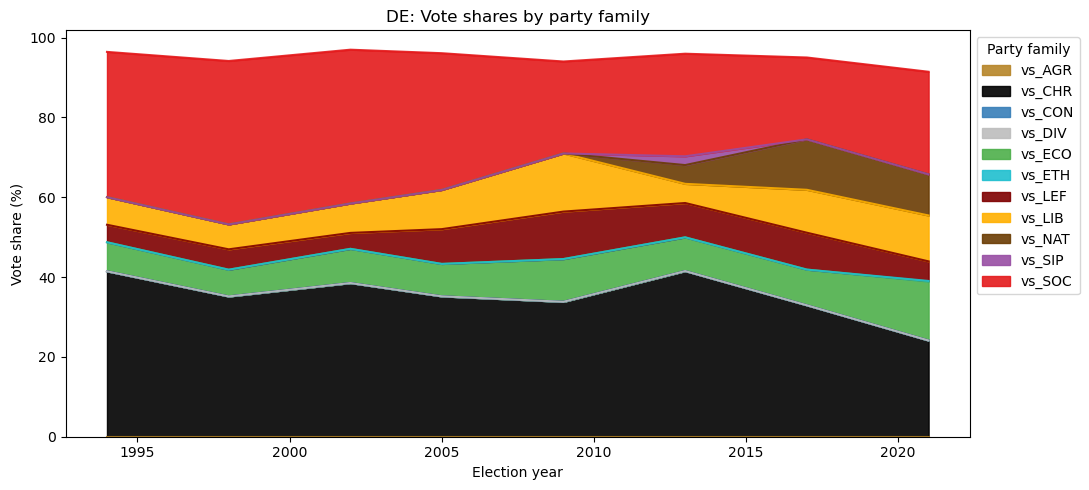

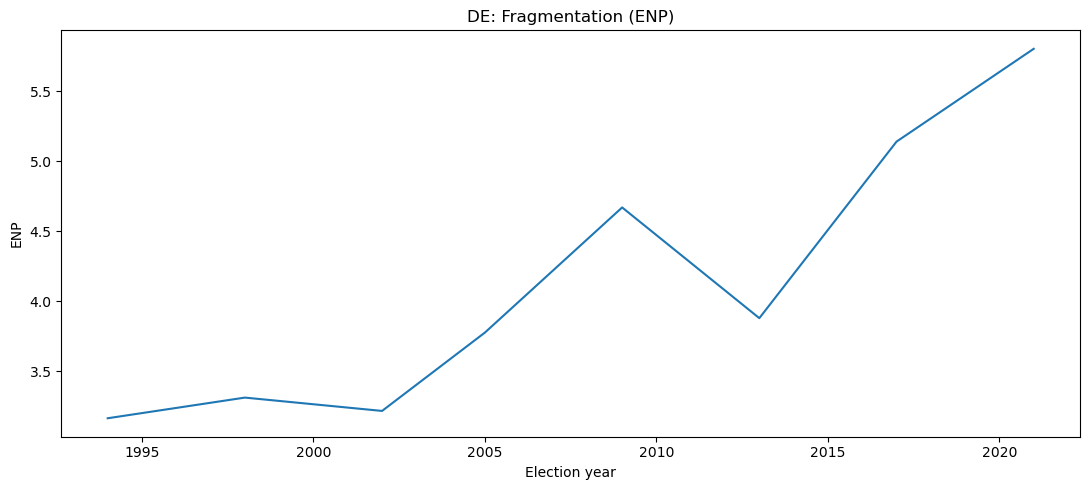

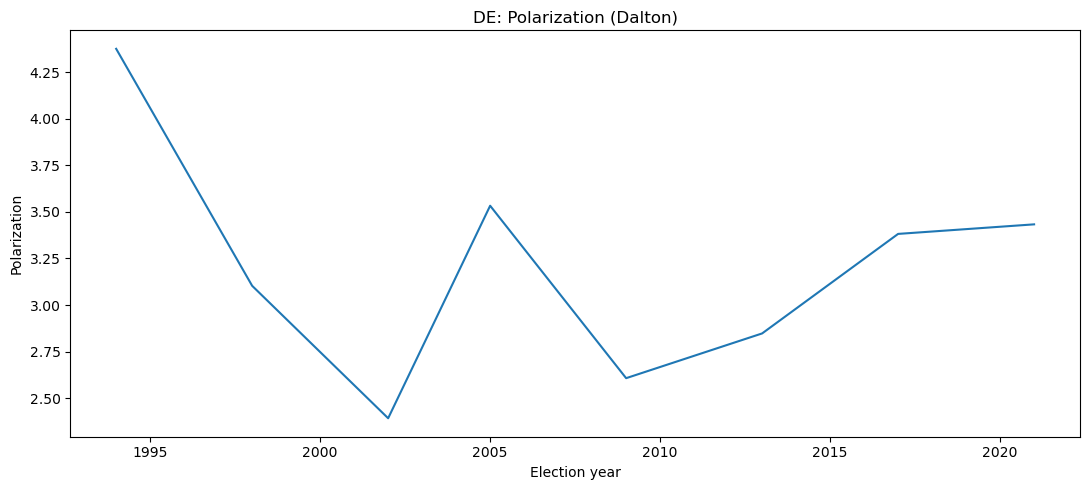

In [28]:
def plot_election_timeseries(countries, elections_df):
    """
    for each country, plots:
        stacked area time series of party-family vote shares,
        time series of fragmentation index and polarization index.
    """

    countries = [c for c in countries if c in elections.index.get_level_values(0)]
    fam = [c for c in elections_df.columns if c.startswith("vs_")]

    for geo in countries:
        d = elections_df.loc[geo].sort_index()

        ax = d[fam].plot.area(stacked=True, figsize=(11,5), alpha=.9, color = FAMILY_COLORS, title=f"{geo}: Vote shares by party family")
        ax.set(xlabel="Election year", ylabel="Vote share (%)")
        ax.legend(loc="upper left", bbox_to_anchor=(1,1), title="Party family")
        plt.tight_layout()
        plt.show()

        ax = d["fragmentation_enp"].plot(figsize=(11,5), title=f"{geo}: Fragmentation (ENP)")
        ax.set(xlabel="Election year", ylabel="ENP")
        plt.tight_layout()
        plt.show()

        ax = d["polarization_dalton"].plot(figsize=(11,5), title=f"{geo}: Polarization (Dalton)")
        ax.set(xlabel="Election year", ylabel="Polarization")
        plt.tight_layout()
        plt.show()

FAMILY_COLORS = {
    "vs_SOC": "#e41a1c",   # Social democratic parties
    "vs_LEF": "#7f0000",   # Socialist or other left parties
    "vs_ECO": "#4daf4a",   # Ecological parties
    "vs_LIB": "#ffb000",   # Liberal parties
    "vs_CHR": "#000000",   # Christian democratic parties
    "vs_CON": "#377eb8",   # Conservative parties
    "vs_NAT": "#6a3c03",   # Nationalist and radical right parties
    "vs_AGR": "#b68528",   # Agrarian parties
    "vs_ETH": "#1fbfcf",   # Ethnic and regional parties
    "vs_SIP": "#984ea3",   # Special issue parties
    "vs_DIV": "#bdbdbd"    # Electoral alliances
}

select_country = ["DE"]
all_countries = sorted(eu_country_abbreviations.values())

# provide all countries or selected countries
plot_election_timeseries(select_country, elections)

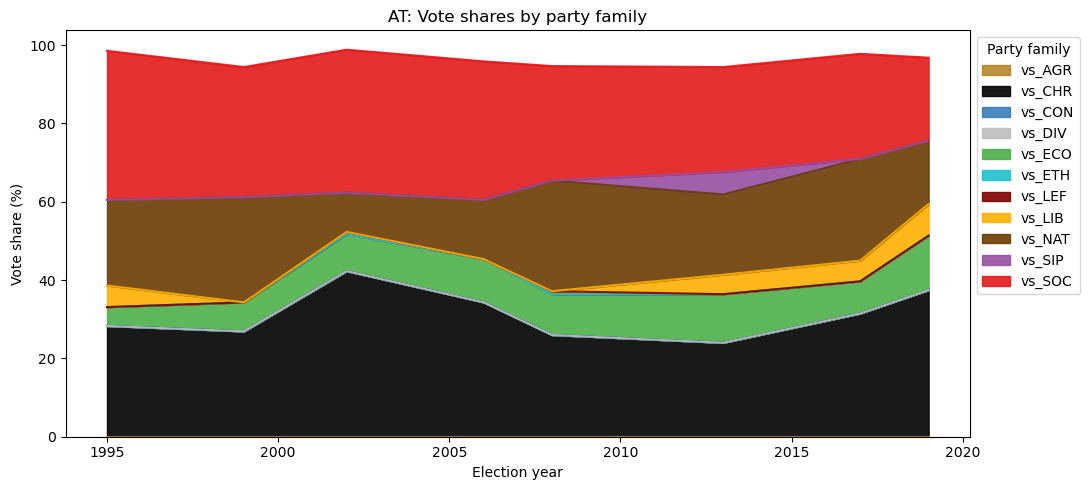

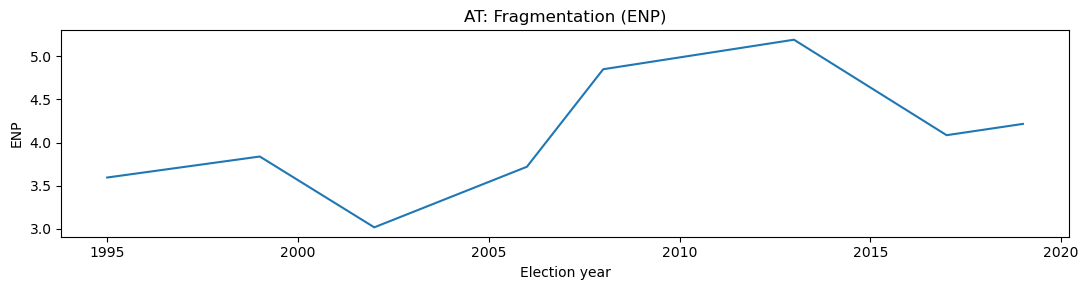

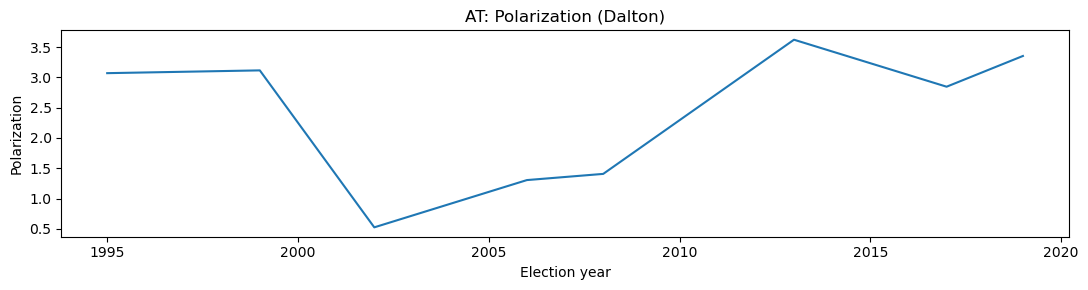


AT — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                CHR      down 2002–2013       -6.66      -18.31
                SOC      down 1995–2019       -2.54      -16.88
                NAT      down 2008–2019       -1.65      -12.07
                CHR        up 2008–2019        4.74       11.48
                NAT        up 2002–2013        5.90       10.50
                ECO        up 1995–2019        1.21        9.09
                LIB        up 2006–2019        2.23        8.10
                NAT      down 1995–2006       -5.91       -6.74
                CHR        up 1995–2006        5.36        6.04
                SIP      down 2013–2019       -2.86       -5.72
  fragmentation_enp        up 2002–2013        0.82        2.17
  fragmentation_enp      down 2008–2019       -0.43       -0.63
polarization_dalton        up 2002–2017        0.77        2.32
polarization_dalton      down 1995–2006       -1.09       -1.77


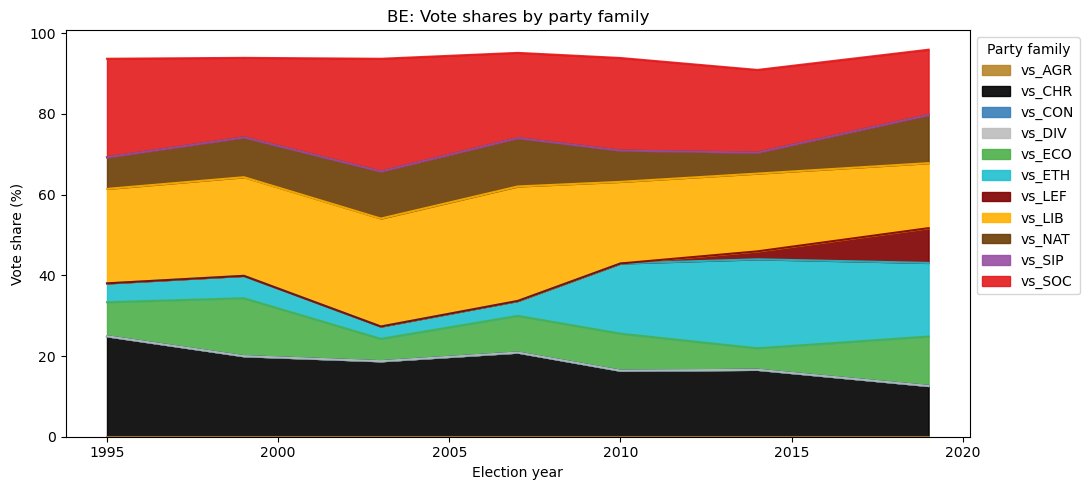

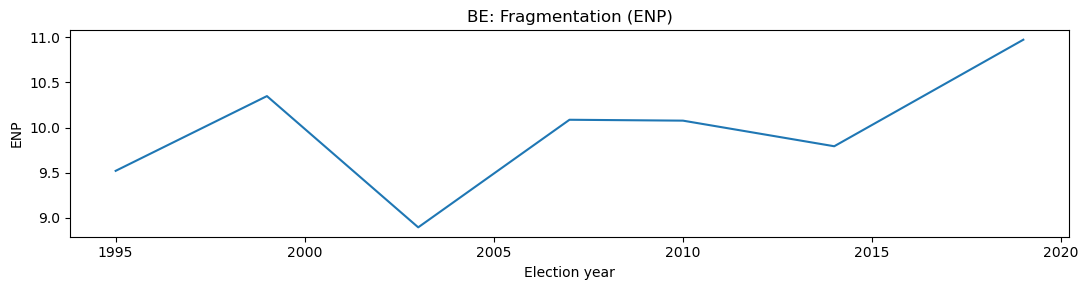

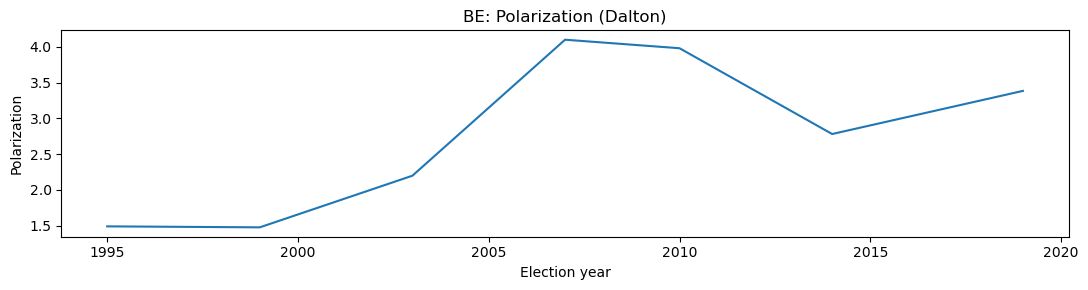


BE — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                ETH        up 2003–2019        5.59       15.18
                CHR      down 1995–2019       -2.07      -12.32
                SOC      down 2003–2019       -2.94      -11.76
                LIB      down 2003–2019       -3.29      -10.64
                LEF        up 2007–2019        2.65        8.62
                ECO        up 2003–2019        1.68        6.71
                NAT      down 2003–2014       -2.68       -6.49
                LIB        up 1995–2007        1.82        4.96
                NAT        up 2010–2019        2.09        4.19
                NAT        up 1995–2007        1.49        4.16
  fragmentation_enp        up 2003–2019        0.52        2.08
  fragmentation_enp      down 1995–2003       -0.31       -0.63
polarization_dalton        up 1995–2010        0.85        2.49
polarization_dalton      down 2007–2019       -0.48       -0.72


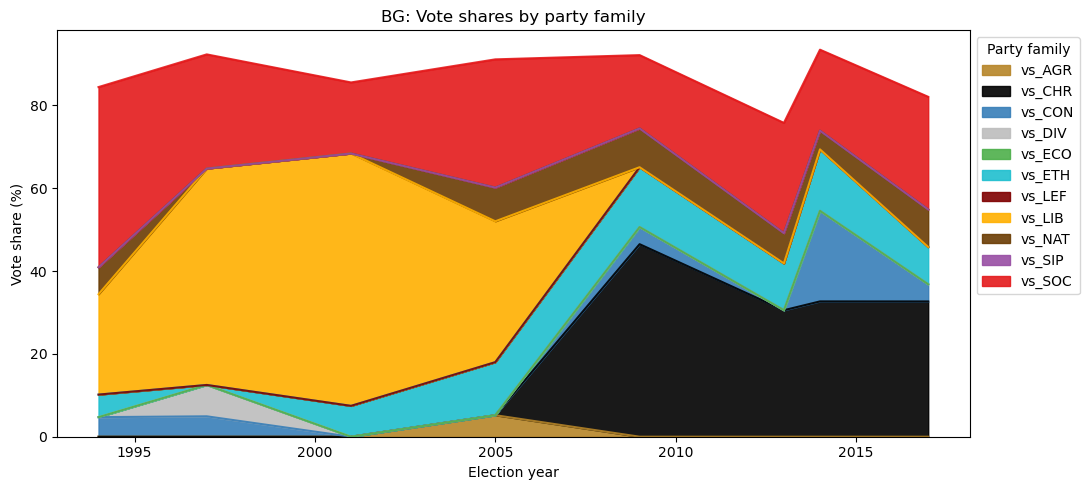

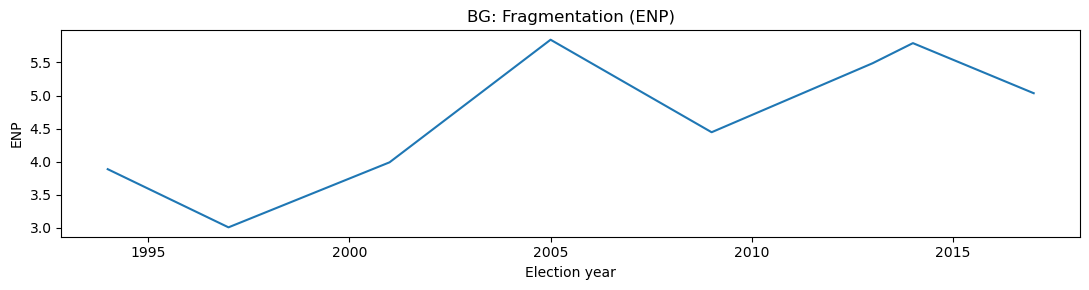

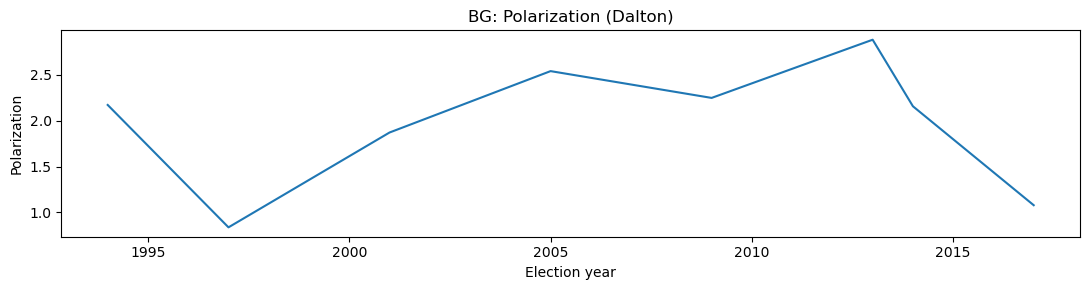


BG — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                LIB      down 1997–2013      -18.86      -52.24
                LIB        up 1994–2001       18.35       36.69
                CHR        up 2001–2017       13.19       32.66
                SOC      down 1994–2001      -13.18      -26.35
                CHR      down 2009–2014       -6.91      -13.81
                NAT        up 1997–2009        4.38        9.36
                ETH        up 1994–2009        3.64        9.00
                DIV      down 1997–2005       -3.78       -7.57
                NAT      down 1994–2001       -3.25       -6.51
                AGR      down 2005–2013       -2.60       -5.19
  fragmentation_enp        up 1997–2014        0.77        2.79
  fragmentation_enp      down 2005–2017       -0.20       -0.81
polarization_dalton        up 1997–2013        0.40        2.05
polarization_dalton      down 2013–2017       -0.90       -1.81


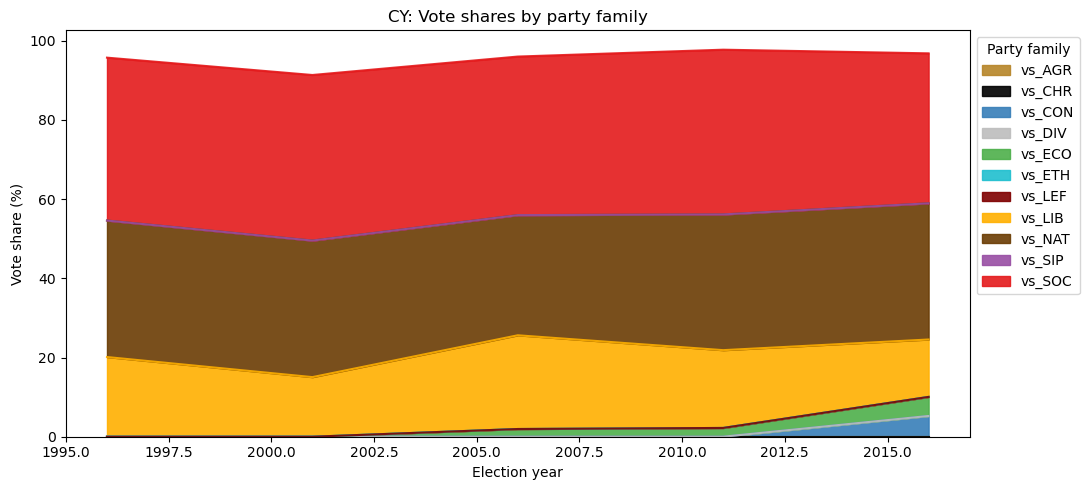

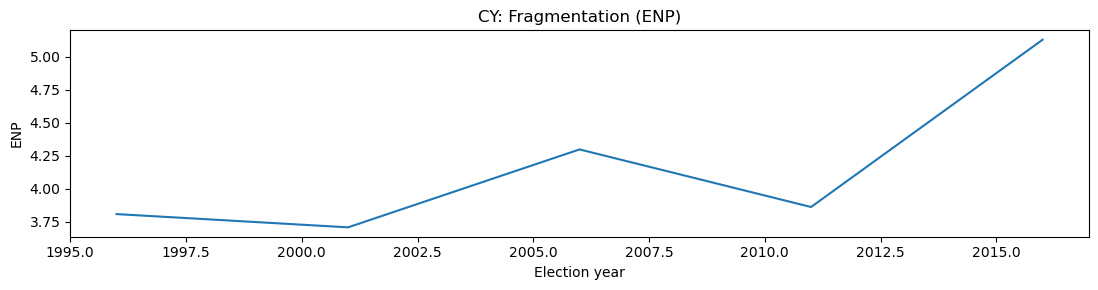

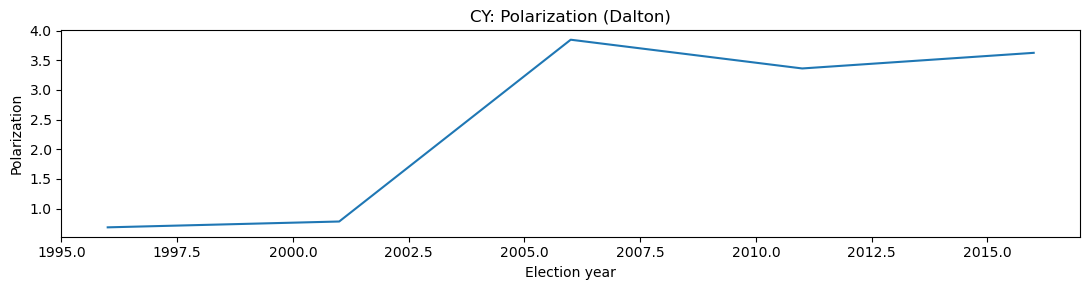


CY — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                LIB      down 2006–2016       -4.59       -9.17
                CON        up 2006–2016        2.62        5.24
                ECO        up 1996–2016        1.17        4.81
                NAT      down 1996–2006       -2.06       -4.13
                NAT        up 2006–2016        2.03        4.05
                SOC      down 1996–2016       -0.82       -3.27
                LIB        up 1996–2011        2.03       -0.48
  fragmentation_enp        up 1996–2016        0.33        1.32
polarization_dalton        up 1996–2011        1.44        2.68


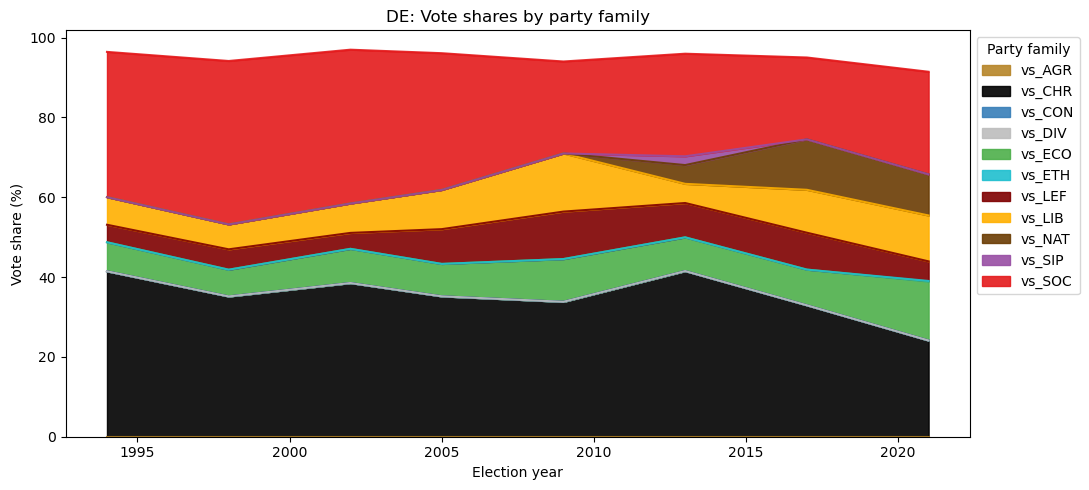

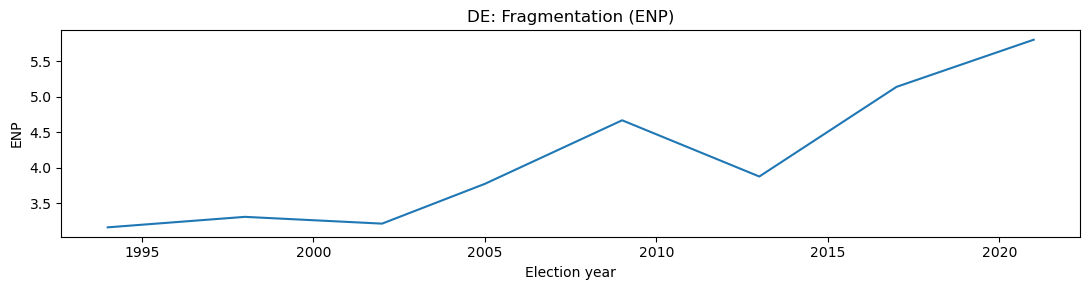

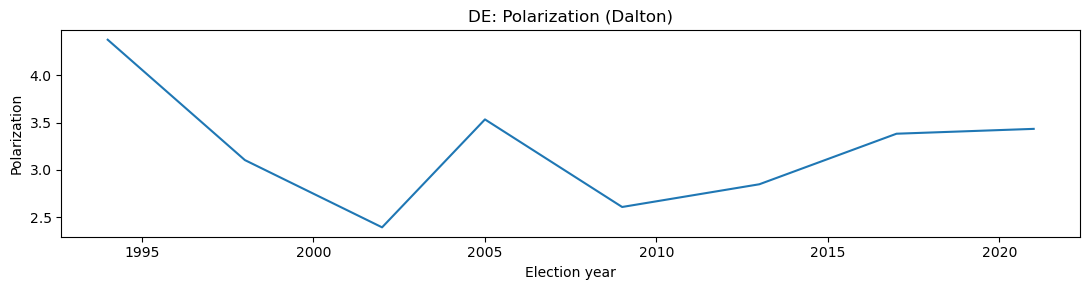


DE — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                SOC      down 1998–2017       -4.16      -20.42
                CHR      down 1994–2021       -3.24      -17.34
                NAT        up 2005–2021        3.82       10.30
                LIB        up 1998–2009        2.69        8.32
                LEF      down 2009–2021       -1.59       -6.99
                LEF        up 1998–2009        2.88        6.79
                LIB        up 2013–2021        3.35        6.70
                ECO        up 2013–2021        3.18        6.36
                CHR        up 2005–2013        3.17        6.33
                ECO        up 1994–2009        0.81        3.44
  fragmentation_enp        up 1998–2021        0.54        2.49
polarization_dalton      down 1994–2002       -0.99       -1.98
polarization_dalton        up 2009–2021        0.34        0.83


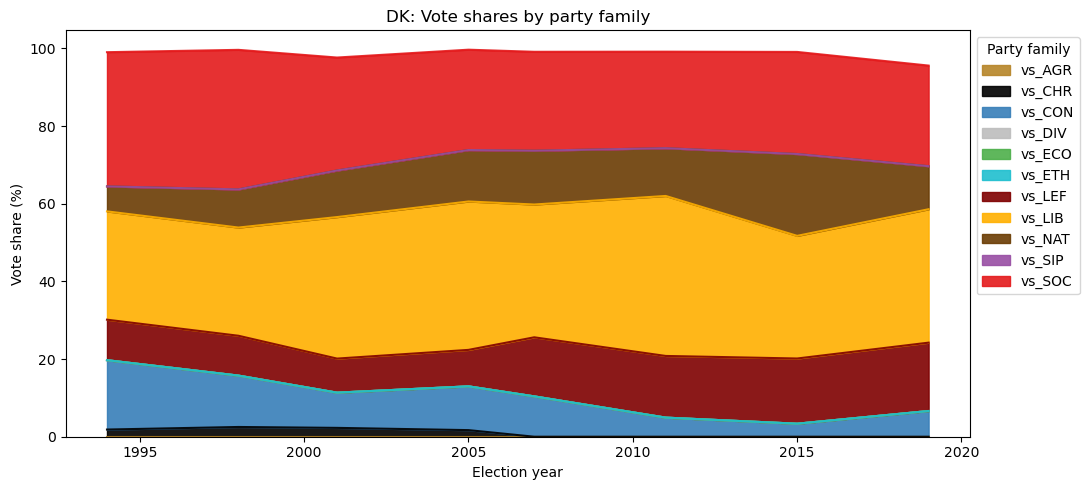

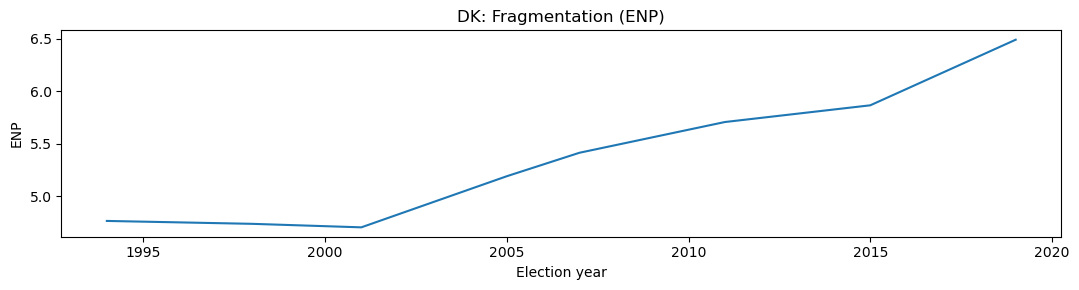

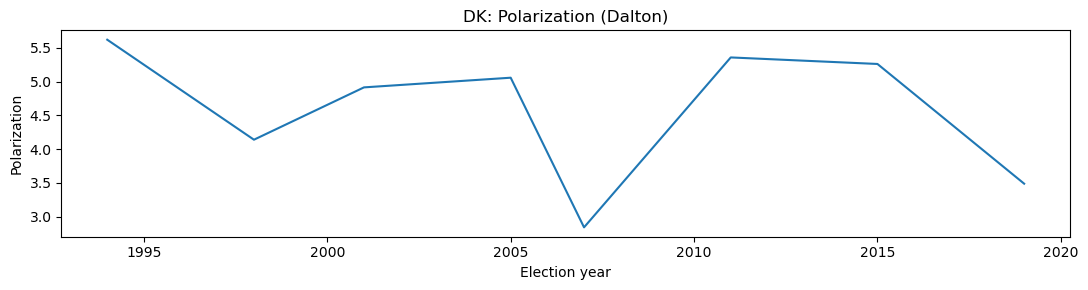


DK — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                NAT        up 1994–2015        2.26       14.64
                CON      down 1994–2015       -3.02      -14.51
                LIB        up 1994–2011        3.65       13.31
                SOC      down 1994–2011       -2.52       -9.70
                LEF        up 2001–2019        2.03        8.83
                CHR      down 1998–2011       -0.80       -2.51
                NAT      down 2005–2019       -0.54       -2.16
                LIB      down 2001–2019       -1.95       -2.09
                CON        up 2011–2019        0.85        1.70
                CON        up 2001–2007        0.66        1.32
  fragmentation_enp        up 1998–2019        0.29        1.76
polarization_dalton      down 1994–2007       -0.69       -2.78
polarization_dalton      down 2011–2019       -0.93       -1.87


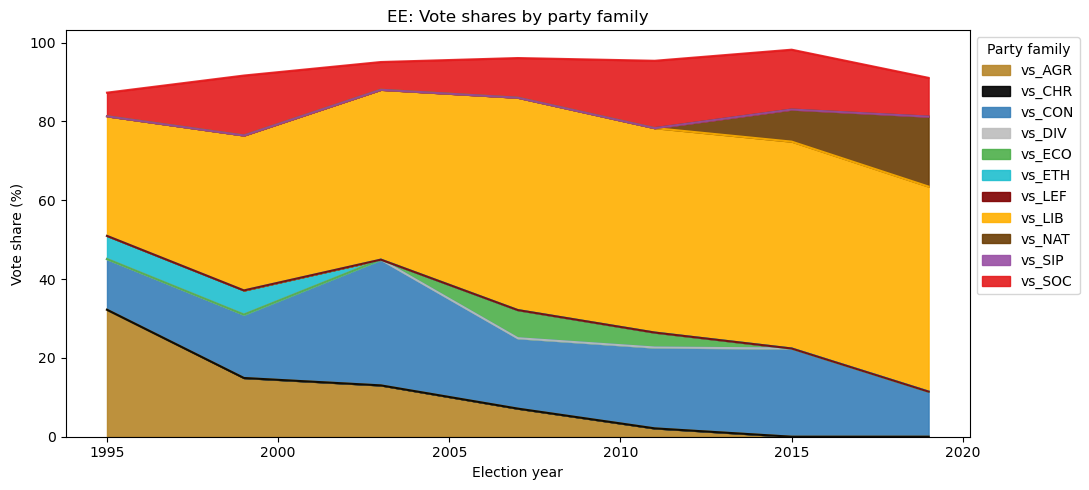

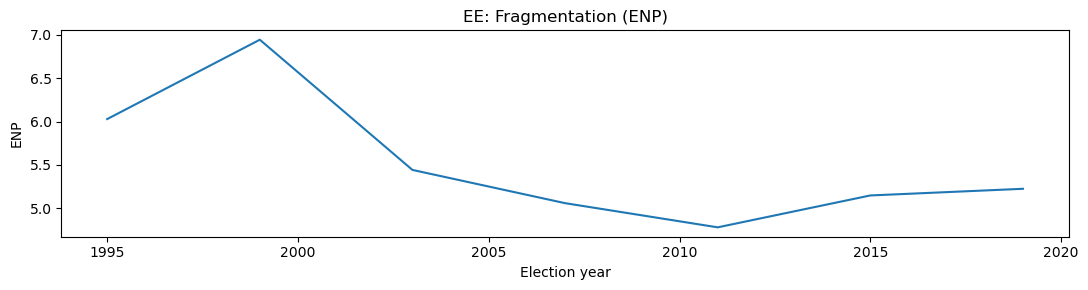

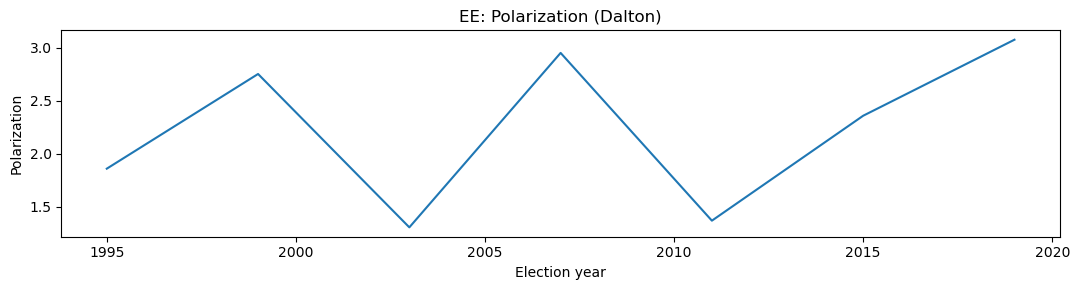


EE — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                AGR      down 1995–2019       -4.71      -32.23
                LIB        up 1995–2011        6.01       21.52
                CON      down 2003–2019       -5.12      -20.47
                NAT        up 2007–2019        6.48       17.76
                CON        up 1995–2015        4.23        9.53
                SOC        up 1995–2015        2.71        9.20
                SOC      down 2011–2019       -3.63       -7.26
                ECO      down 2007–2019       -2.73       -7.14
                ETH      down 1995–2007       -3.00       -5.87
                SOC      down 1999–2007       -2.57       -5.14
  fragmentation_enp      down 1995–2011       -0.52       -1.25
  fragmentation_enp        up 2011–2019        0.22        0.44
polarization_dalton        up 2011–2019        0.85        1.71
polarization_dalton      down 2007–2015       -0.30       -0.59


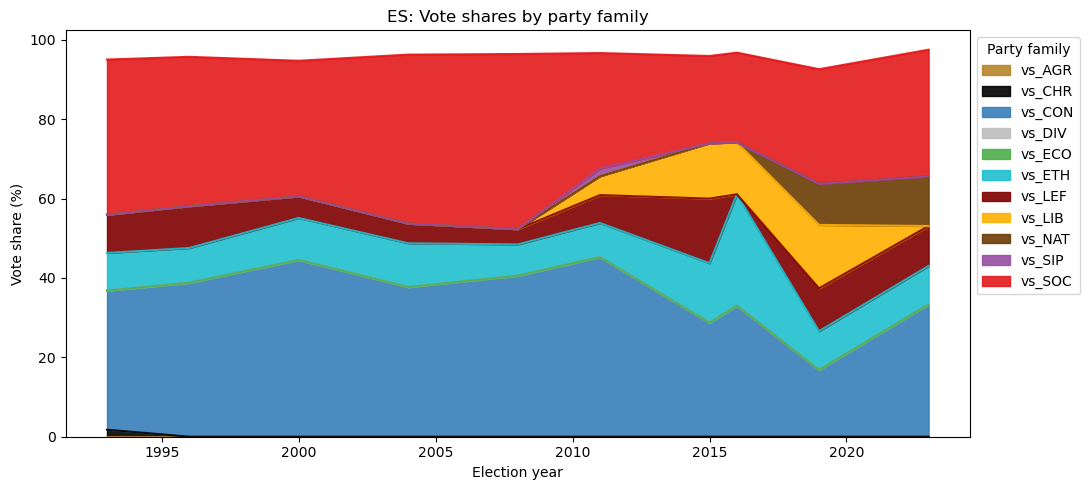

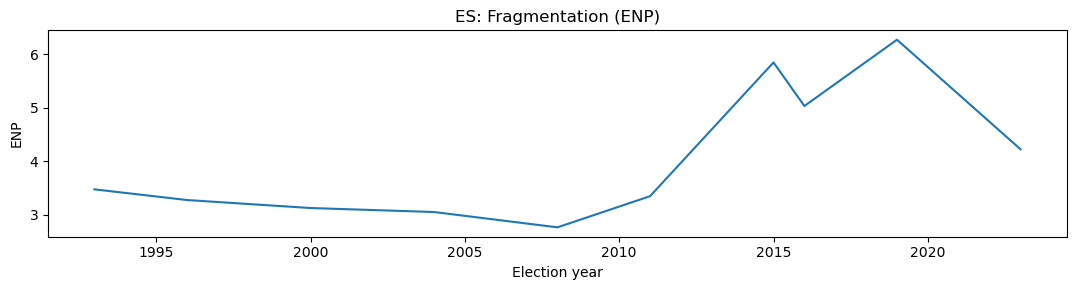

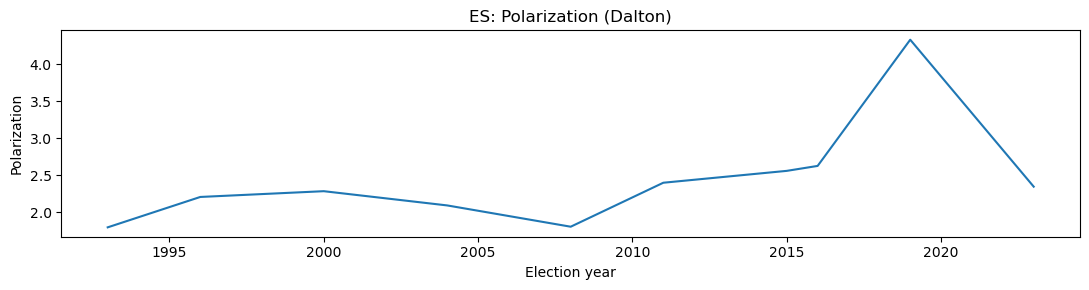


ES — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                CON      down 1996–2019       -4.10      -21.96
                ETH        up 2008–2016        6.65       20.19
                SOC      down 2004–2016       -7.02      -19.95
                LIB        up 2004–2019        3.63       15.98
                LIB      down 2016–2023       -6.53      -13.06
                NAT        up 2015–2023        5.71       12.48
                LEF        up 2004–2015        3.62       11.32
                LEF        up 2016–2023        5.02       10.04
                SOC        up 2015–2023        4.05        9.95
                CON        up 1993–2000        4.74        9.48
  fragmentation_enp        up 2008–2019        0.87        3.51
  fragmentation_enp      down 2016–2023       -0.40       -0.81
polarization_dalton        up 2004–2019        0.47        2.24
polarization_dalton        up 1993–2000        0.24        0.49


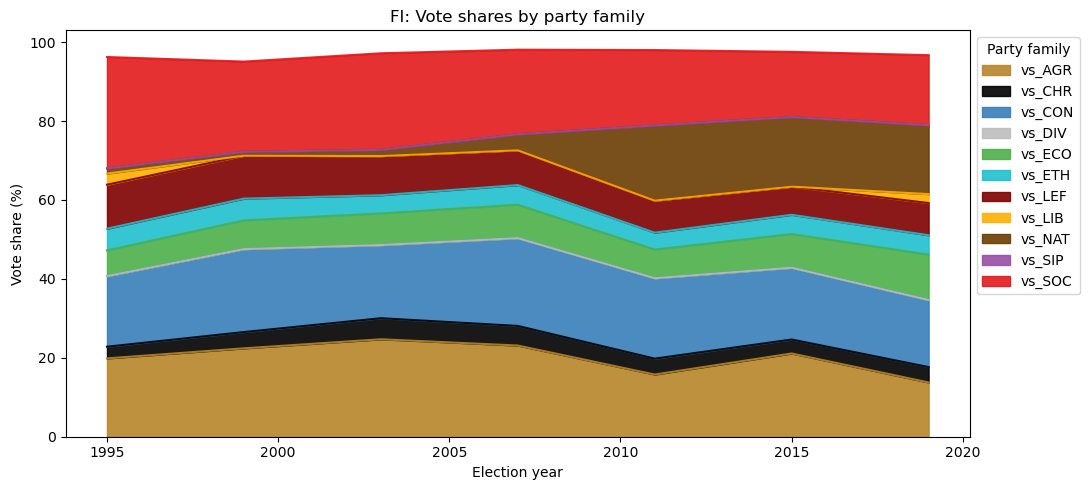

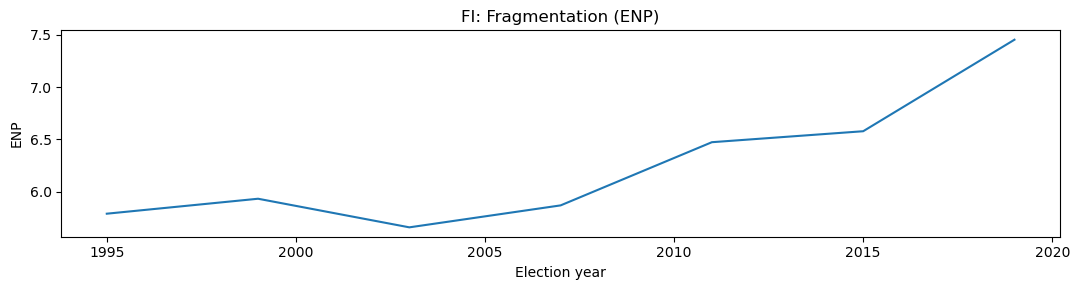

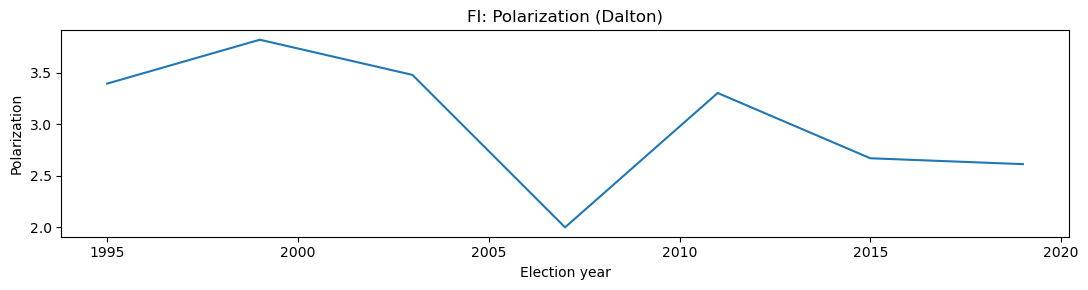


FI — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                NAT        up 1999–2015        5.69       16.66
                AGR      down 2003–2019       -2.16      -10.94
                SOC      down 1995–2019       -1.69      -10.52
                CON      down 2007–2019       -1.86       -5.26
                AGR        up 1995–2003        2.42        4.84
                ECO        up 2011–2019        2.12        4.24
                LEF      down 1995–2015       -0.85       -4.03
                LIB      down 1995–2003       -1.40       -2.81
                LIB        up 2011–2019        1.13        2.25
                CHR        up 1995–2007        0.81        2.01
  fragmentation_enp        up 2003–2019        0.42        1.80
polarization_dalton      down 1999–2007       -0.91       -1.82
polarization_dalton      down 2011–2019       -0.35       -0.69


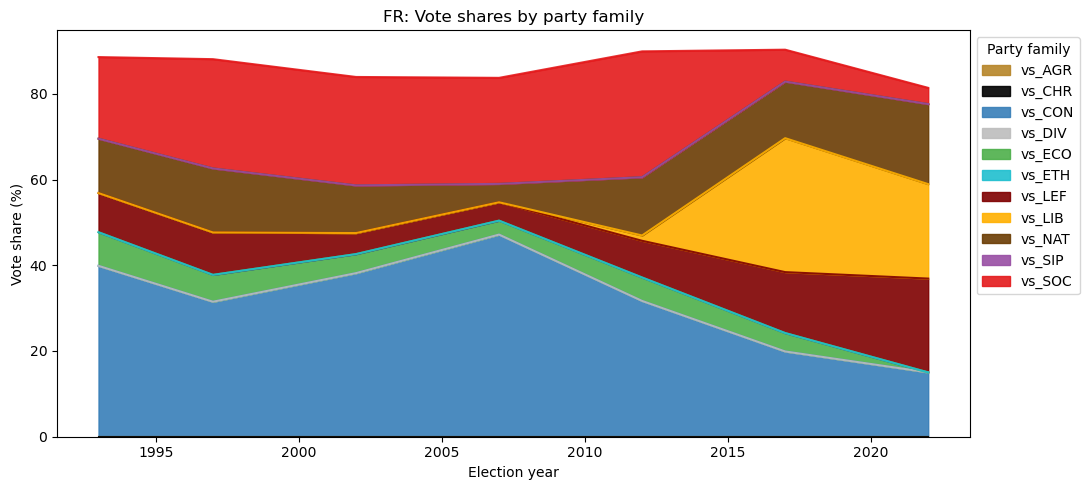

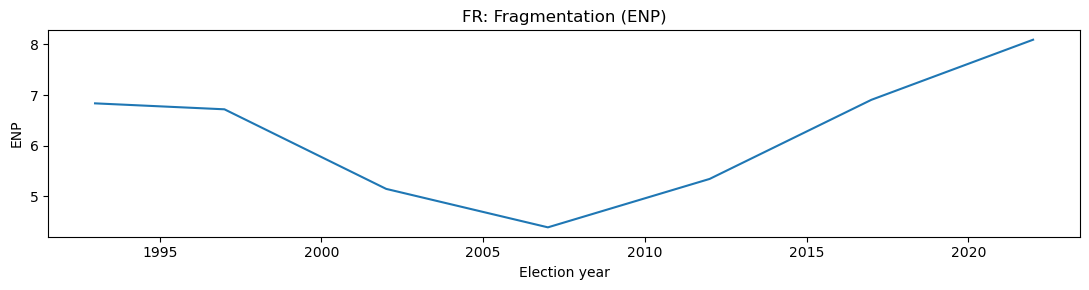

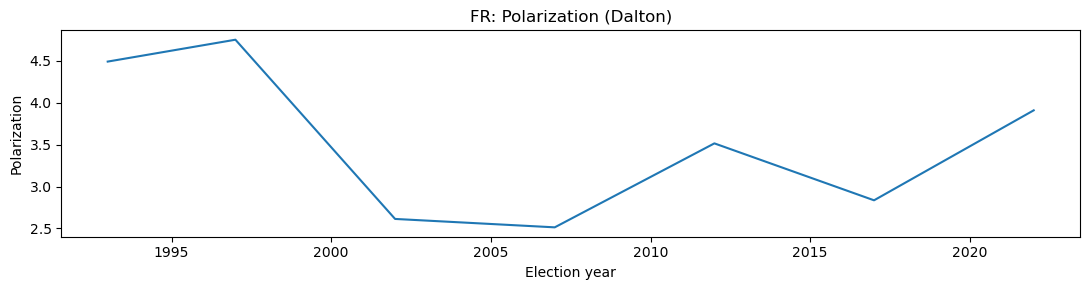


FR — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                CON      down 1993–2022       -6.51      -24.85
                LIB        up 2002–2022        8.88       22.03
                SOC      down 2007–2022      -10.72      -20.95
                LEF        up 2002–2022        4.48       16.97
                CON        up 1997–2007        7.83       15.66
                SOC        up 1993–2012        2.58       10.31
                NAT      down 1993–2007       -3.05       -8.39
                NAT        up 2002–2022        2.75        7.56
                ECO      down 2012–2022       -2.73       -5.46
                LEF      down 1993–2007       -2.46       -4.85
  fragmentation_enp        up 2007–2022        1.32        3.71
  fragmentation_enp      down 1993–2007       -1.01       -2.45
polarization_dalton      down 1993–2007       -1.03       -1.97
polarization_dalton        up 2002–2022        0.27        1.29


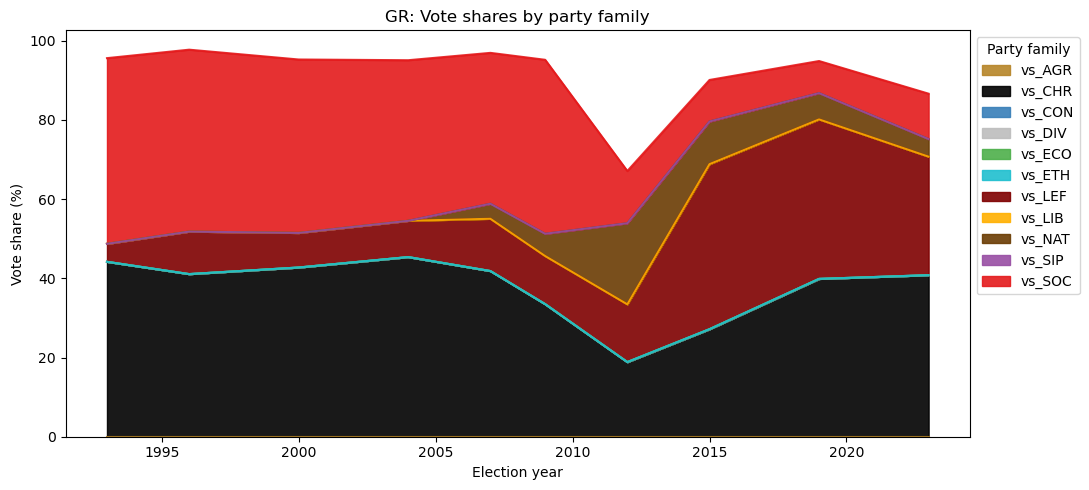

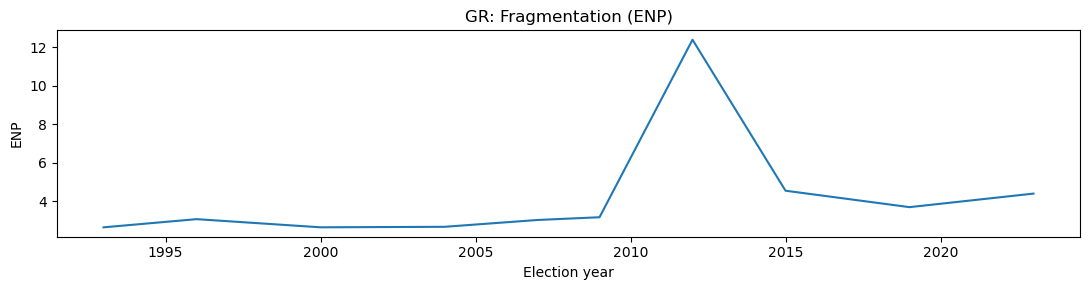

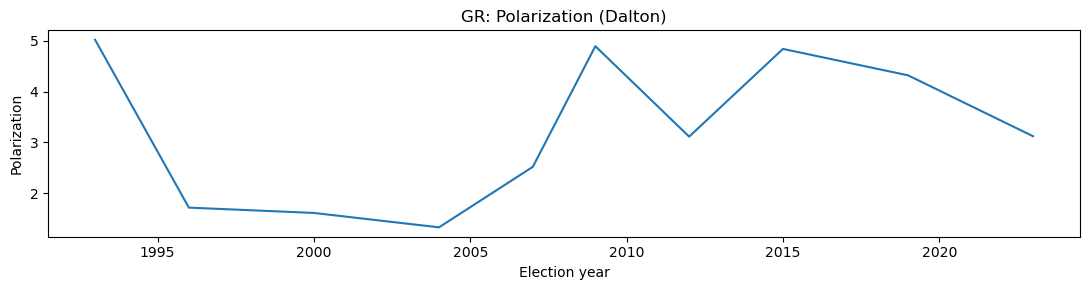


GR — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                SOC      down 1993–2019       -6.47      -38.78
                LEF        up 1993–2019        5.69       35.73
                CHR        up 2012–2023        8.66       21.94
                CHR      down 1993–2015       -4.35      -17.02
                NAT      down 2012–2023       -5.04      -16.03
                LEF      down 2015–2023       -5.88      -11.76
                NAT        up 2000–2015        3.91       10.77
                CHR        up 1996–2004        2.15        4.29
                SOC        up 2004–2009        1.69        3.38
                LEF      down 1996–2004       -0.79       -1.57
  fragmentation_enp      down 2012–2019       -4.35       -8.69
  fragmentation_enp        up 2000–2015        1.45        1.90
polarization_dalton      down 1993–2004       -0.95       -3.69
polarization_dalton        up 2000–2019        0.78        2.71


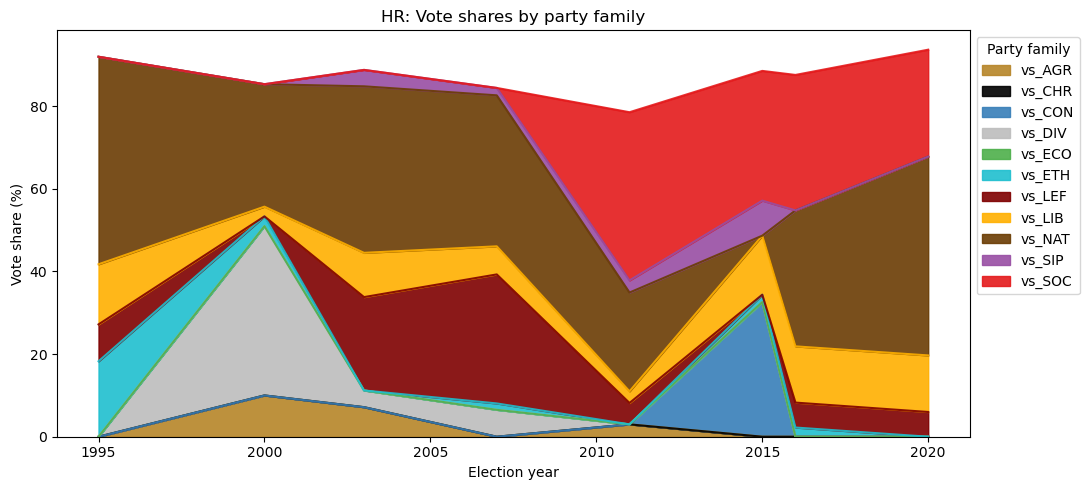

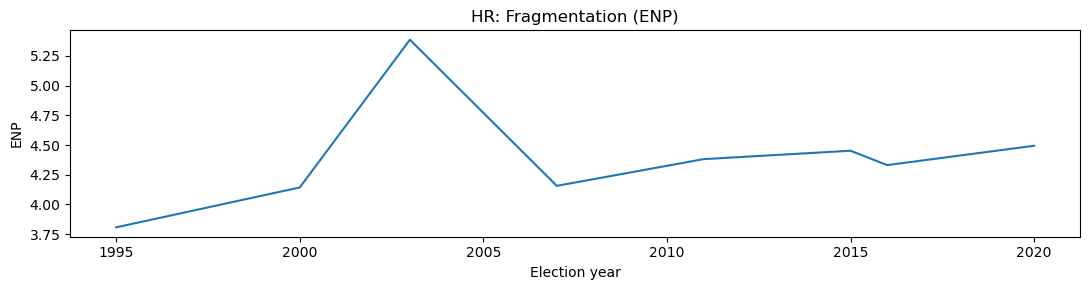

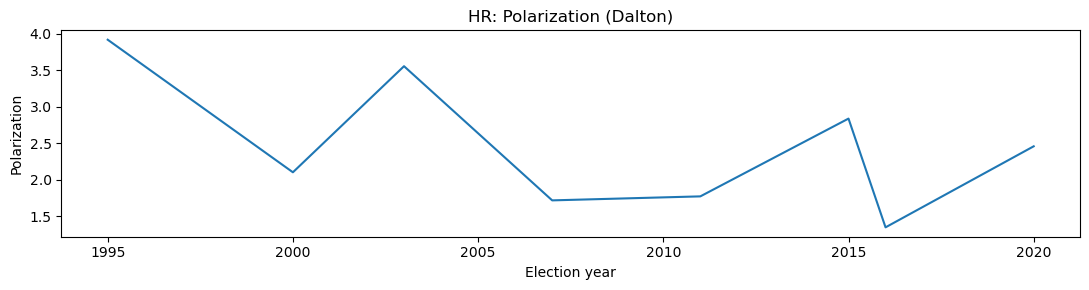


HR — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                NAT      down 1995–2015      -10.48      -50.24
                DIV      down 2000–2015       -7.51      -40.99
                CON      down 2015–2020      -16.30      -32.59
                CON        up 2007–2015       16.30       32.59
                SOC        up 2003–2015       18.03       31.40
                NAT        up 2011–2020       14.28       24.22
                LEF      down 2003–2015      -12.16      -22.60
                LEF        up 1995–2007       11.23       22.30
                ETH      down 1995–2007       -4.77      -16.72
                SOC      down 2011–2020       -3.36      -14.85
  fragmentation_enp        up 1995–2003        0.79        1.58
  fragmentation_enp      down 2003–2011       -0.50       -1.01
polarization_dalton      down 1995–2020       -0.33       -1.46
polarization_dalton        up 2007–2015        0.56        1.12


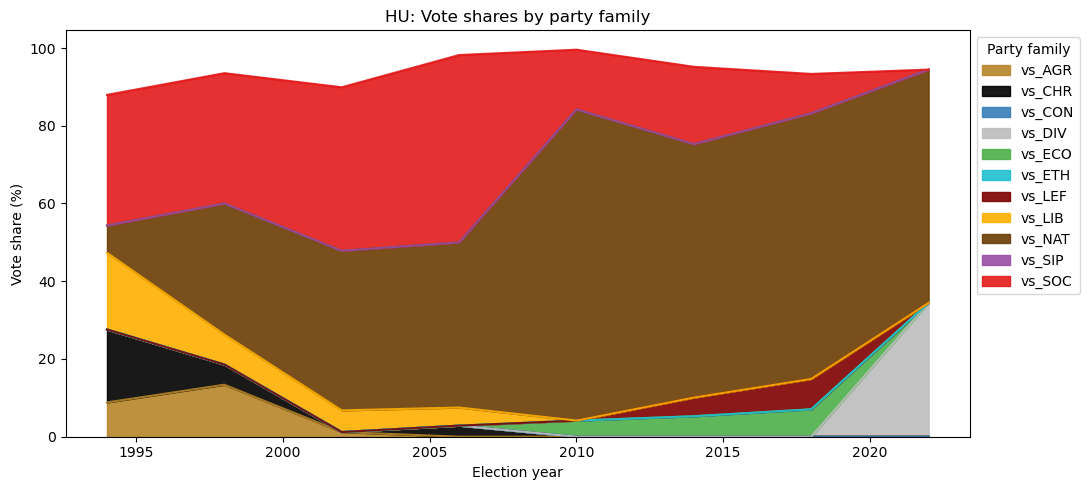

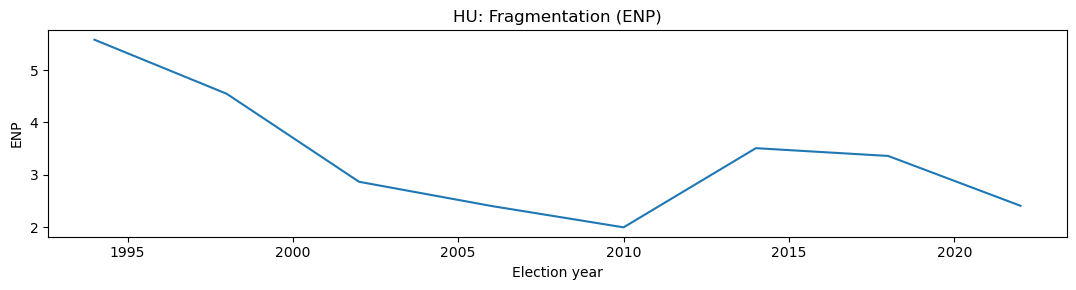

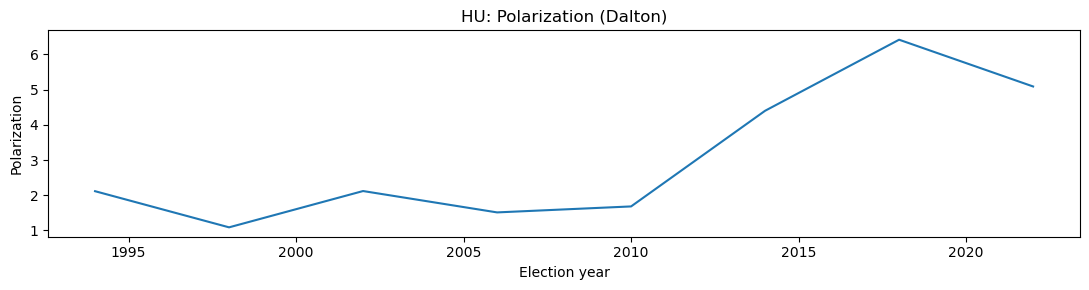


HU — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                NAT        up 1994–2014       13.06       58.19
                SOC      down 2002–2022      -10.01      -42.05
                DIV        up 2014–2022       17.22       34.44
                NAT      down 2010–2022       -4.23      -20.05
                LIB      down 1994–2014       -3.43      -19.74
                CHR      down 1994–2014       -3.99      -18.76
                SOC        up 1994–2006        5.79       14.60
                AGR      down 1994–2010       -3.70       -8.82
                LEF        up 2006–2018        3.15        7.82
                ECO        up 2002–2018        2.05        7.06
  fragmentation_enp      down 1994–2010       -0.95       -3.58
  fragmentation_enp      down 2014–2022       -0.55       -1.10
polarization_dalton        up 1998–2022        1.09        4.00
polarization_dalton      down 2002–2010       -0.22       -0.44


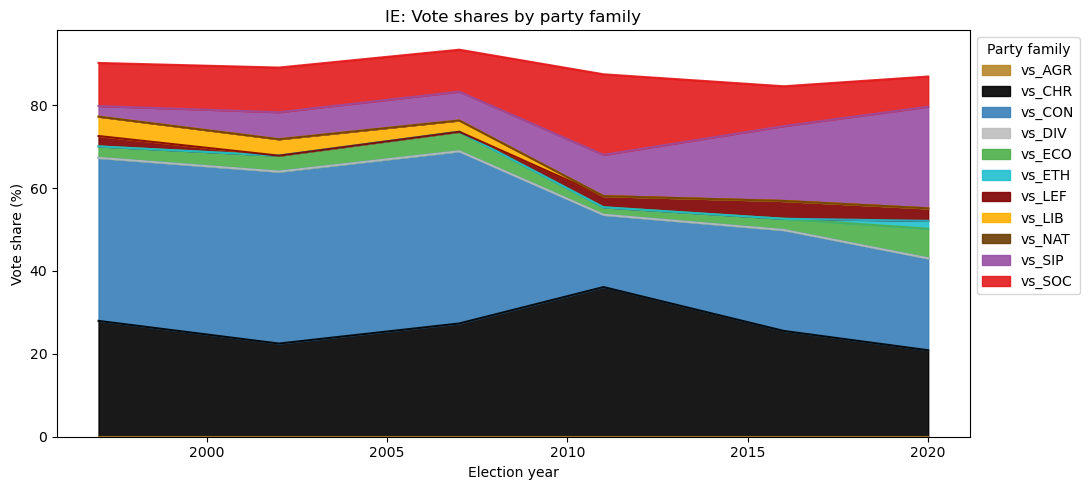

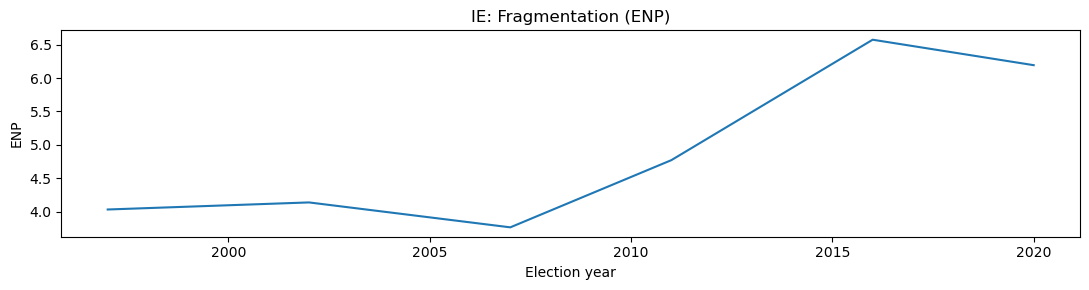

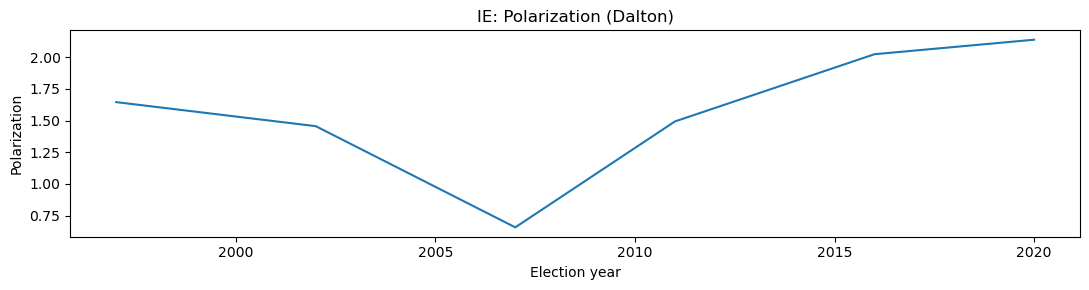


IE — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                SIP        up 1997–2020        4.19       21.98
                CON      down 2002–2016      -10.31      -17.13
                CHR        up 2002–2011        6.81       13.63
                SOC      down 2011–2020       -6.08      -12.17
                SOC        up 2002–2011        4.34        8.67
                CHR      down 2007–2020       -4.26       -6.46
                ECO        up 2011–2020        2.67        5.33
                CON        up 2011–2020        2.37        4.73
                LIB      down 1997–2016       -1.44       -4.68
                LEF        up 2002–2016        1.75        4.30
  fragmentation_enp        up 2002–2020        0.81        2.05
polarization_dalton        up 2007–2020        0.50        1.48
polarization_dalton      down 1997–2007       -0.49       -0.99


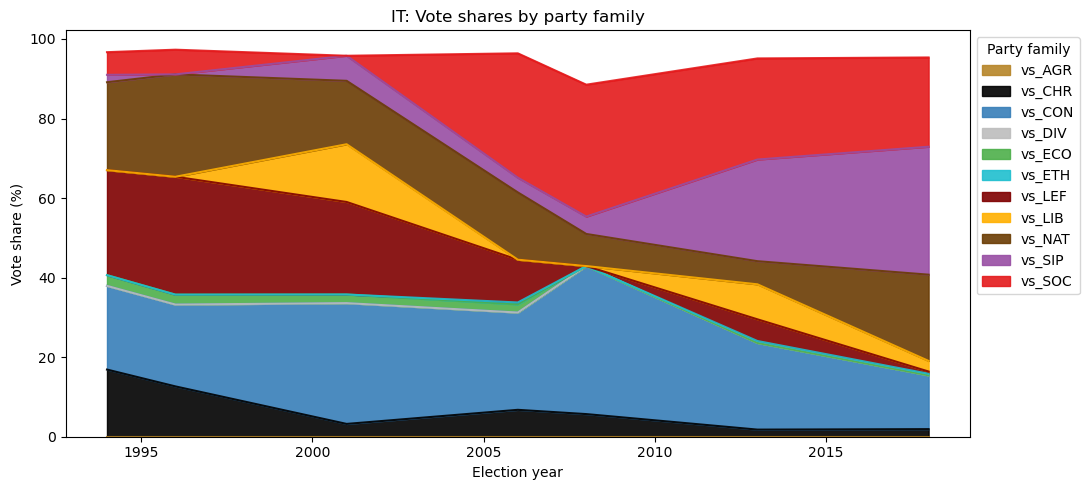

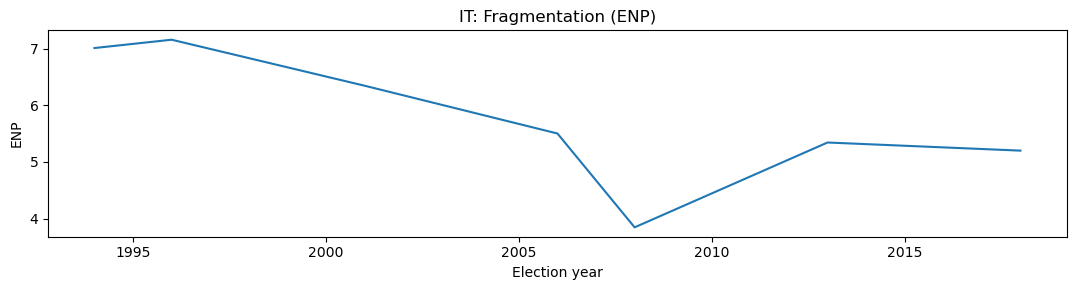

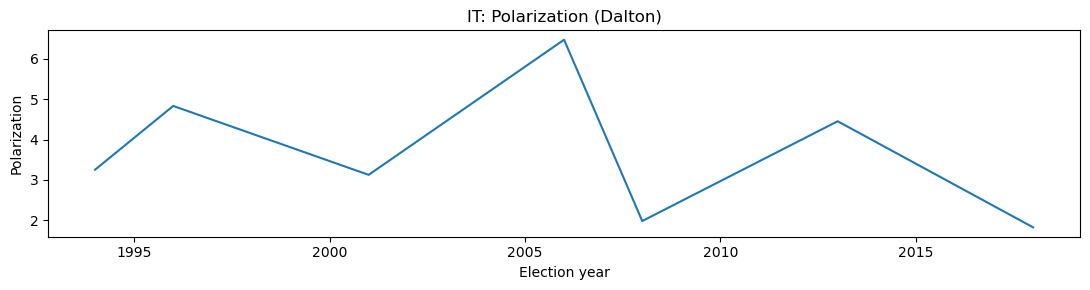


IT — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                SIP        up 1994–2018        7.22       30.30
                SOC        up 1996–2008       14.56       26.96
                LEF      down 1994–2013       -6.32      -20.95
                NAT      down 1994–2013       -4.24      -16.28
                CON        up 1994–2008        3.34       16.18
                CHR      down 1994–2018       -3.54      -14.97
                LIB      down 2001–2008       -7.26      -14.51
                LIB        up 1994–2001        7.26       14.51
                NAT        up 2008–2018        6.81       13.62
                CON      down 2006–2018       -6.59      -10.93
  fragmentation_enp      down 1994–2008       -0.80       -3.17
  fragmentation_enp        up 2008–2018        0.68        1.36
polarization_dalton        up 1996–2006        0.82        1.64
polarization_dalton      down 2001–2013       -0.79        1.33


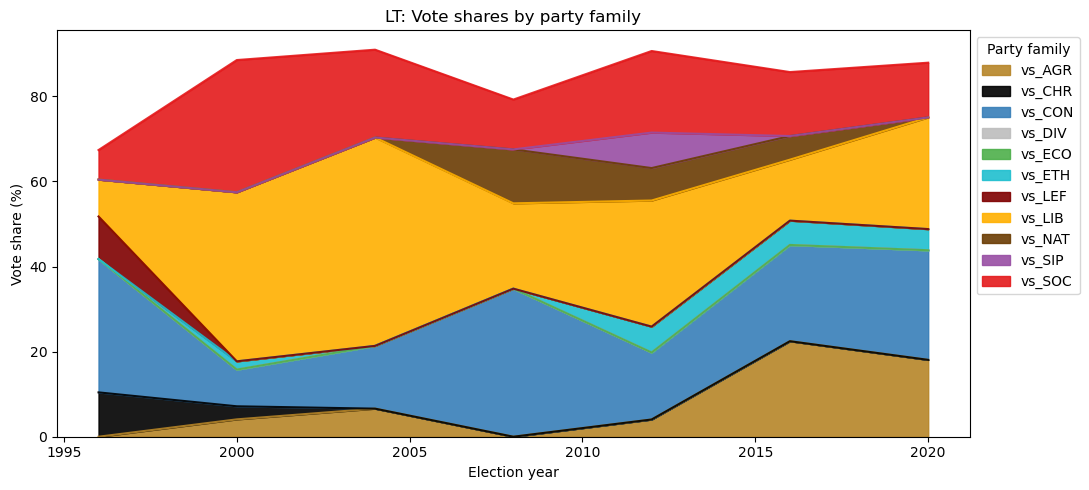

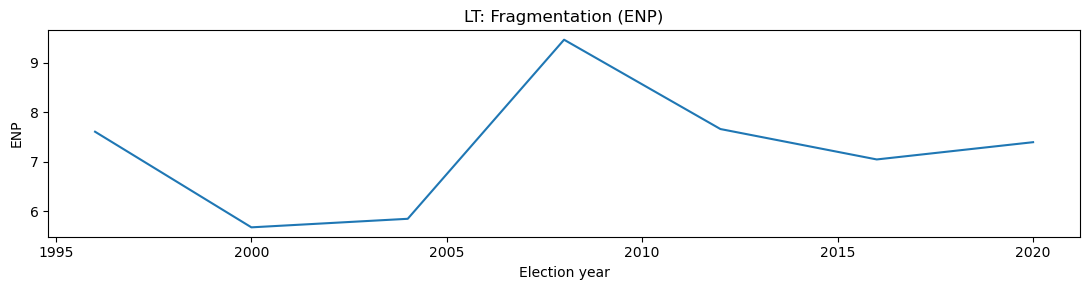

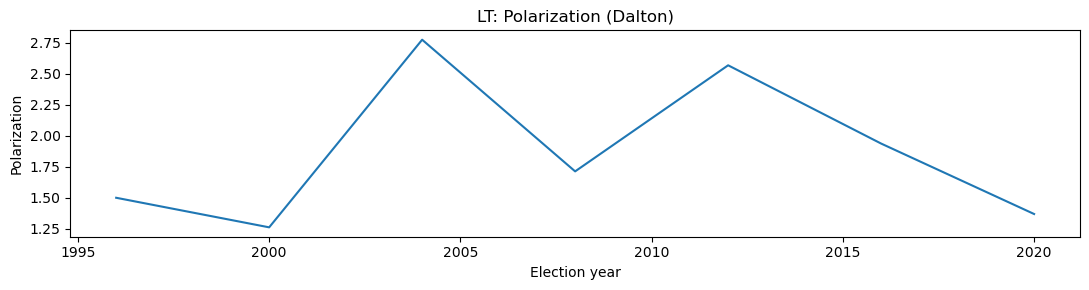


LT — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                LIB        up 1996–2004       20.16       40.31
                SOC      down 2000–2020       -4.52      -18.22
                AGR        up 2008–2020        9.12       18.07
                CON        up 2000–2020        6.20       17.15
                CON      down 1996–2004       -8.29      -16.59
                SOC        up 1996–2004        6.85       13.70
                LIB      down 2000–2020       -6.02      -13.49
                NAT      down 2008–2020       -3.69      -12.68
                CON      down 2008–2016       -6.09      -12.18
                CHR      down 1996–2008       -3.38      -10.43
  fragmentation_enp      down 2008–2016       -1.21       -2.42
  fragmentation_enp        up 2000–2012        1.40        1.98
polarization_dalton      down 2012–2020       -0.60       -1.20
polarization_dalton        up 1996–2008        0.43        0.21


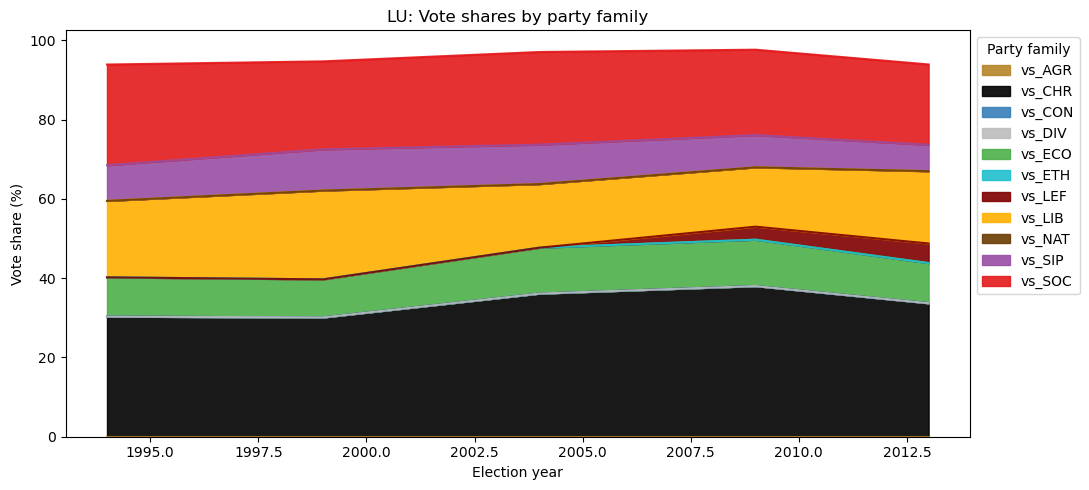

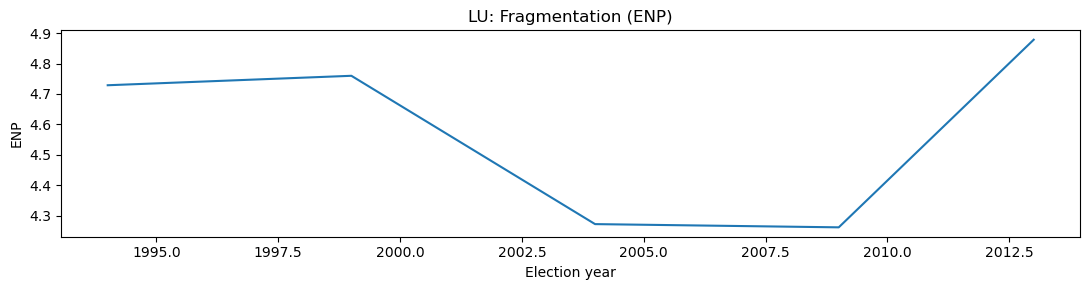

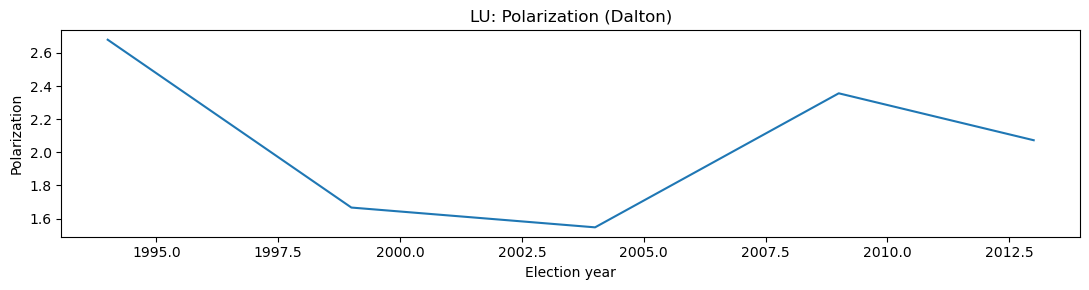


LU — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                CHR        up 1994–2009        3.43        7.71
                SOC      down 1994–2013       -1.28       -5.12
                LEF        up 1999–2013        2.06        4.94
                LIB      down 1994–2009       -2.67       -4.33
                SIP      down 1999–2013       -1.39       -3.76
                CHR      down 2004–2013       -1.22       -2.43
                LIB        up 2004–2013        1.10        2.20
                ECO        up 1994–2009        0.95        1.80
                ECO      down 2004–2013       -0.72       -1.45
                SIP        up 1994–2004        0.47        0.95
  fragmentation_enp        up 2004–2013        0.30        0.61
  fragmentation_enp      down 1994–2009       -0.24       -0.47
polarization_dalton      down 1994–2004       -0.57       -1.13
polarization_dalton        up 1999–2013        0.30        0.41


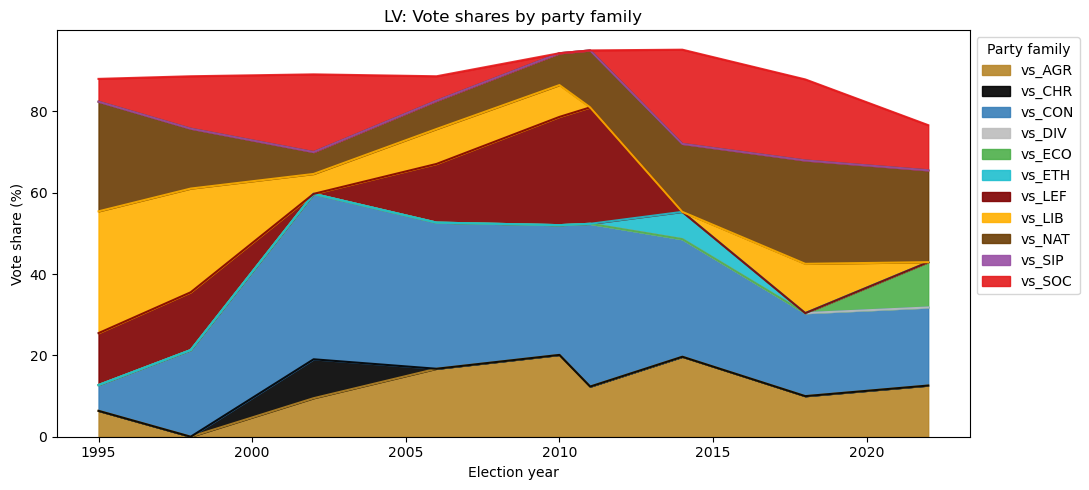

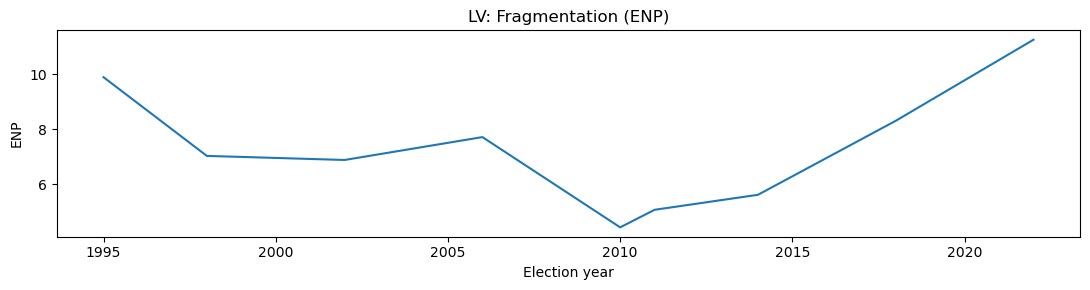

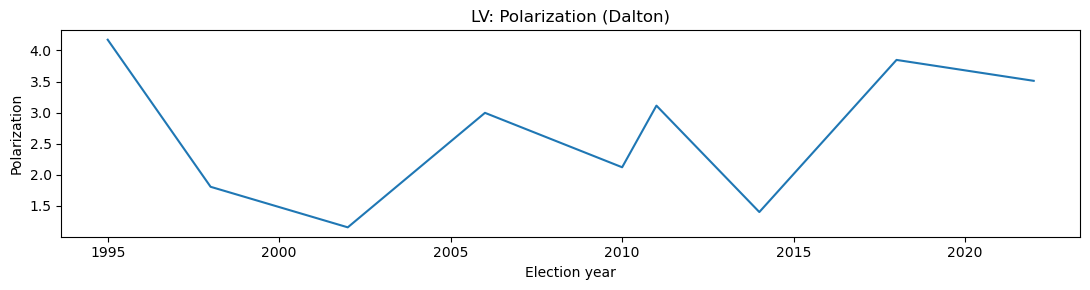


LV — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                CON        up 1995–2011        8.84       33.67
                LIB      down 1995–2014       -7.30      -29.94
                LEF        up 2002–2011       10.20       28.62
                LEF      down 2010–2018      -13.81      -26.61
                CON      down 2002–2022       -5.13      -21.47
                NAT      down 1995–2006       -7.34      -20.02
                SOC        up 2010–2018       10.77       19.92
                NAT        up 2002–2022        3.57       17.20
                AGR        up 1995–2010        5.08       13.75
                SOC        up 1995–2002        6.74       13.49
  fragmentation_enp        up 2010–2022        1.67        6.81
  fragmentation_enp      down 1995–2011       -1.35       -4.82
polarization_dalton      down 1995–2002       -1.51       -3.02
polarization_dalton      down 2010–2014       -0.36       -0.72


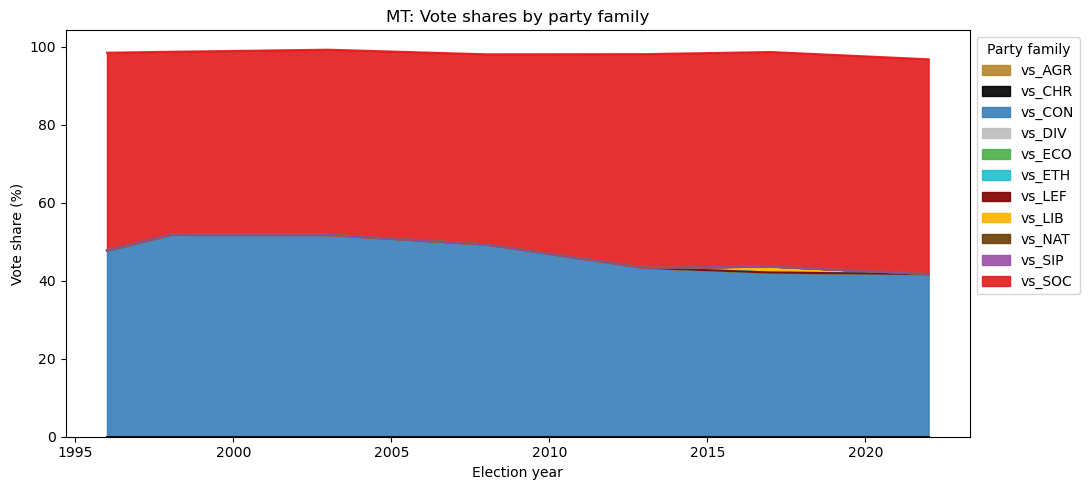

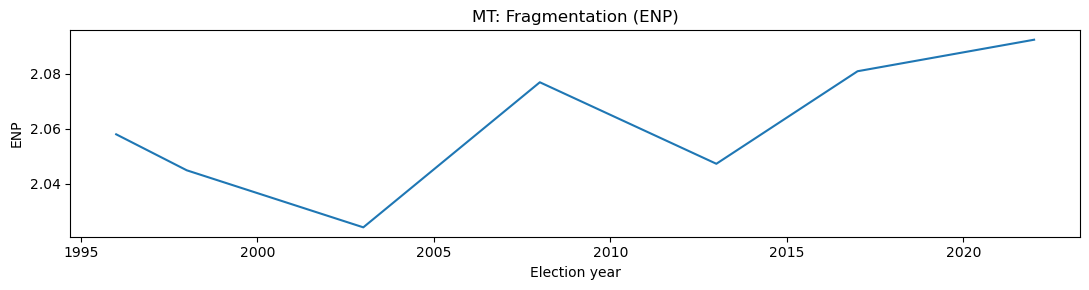

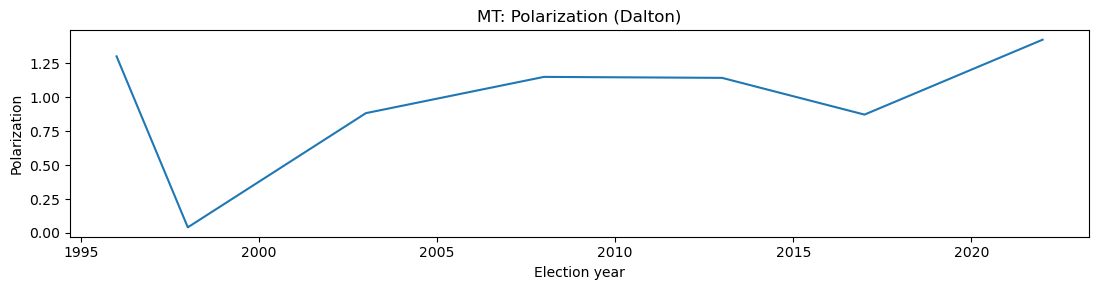


MT — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                CON      down 1998–2022       -2.47      -10.07
                SOC        up 1998–2017        2.56        8.07
                CON        up 1996–2003        1.99        3.99
                SOC      down 1996–2003       -1.61       -3.22
                LIB        up 2008–2017        0.78        1.56
polarization_dalton        up 1998–2008        0.55        1.11
polarization_dalton      down 1996–2003       -0.21       -0.42


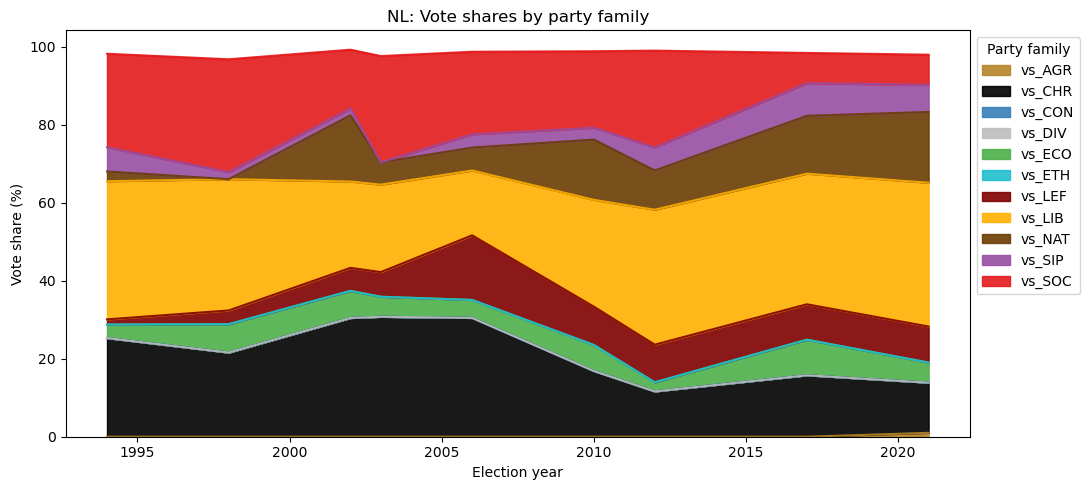

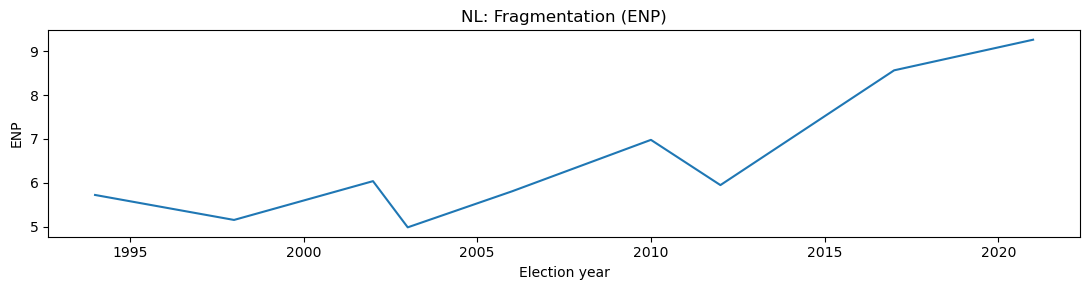

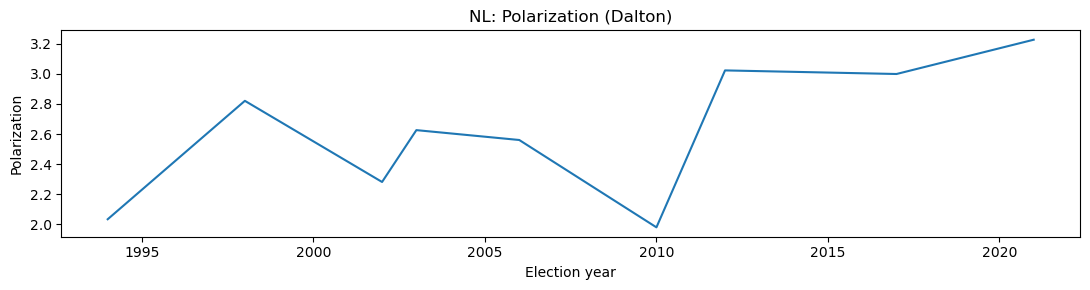


NL — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                LIB      down 1994–2006       -5.01      -18.81
                SOC      down 1994–2021       -4.72      -16.22
                NAT        up 1994–2021        4.22       15.67
                CHR      down 2003–2017       -5.64      -15.01
                LIB        up 2003–2021        3.92       14.46
                NAT      down 2002–2006       -5.56      -11.11
                SOC        up 2002–2012        2.43        9.73
                LEF        up 1994–2010        2.69        8.51
                LEF      down 2006–2012       -3.46       -6.92
                SIP      down 1994–2003       -1.57       -6.23
  fragmentation_enp        up 2003–2021        1.15        4.28
  fragmentation_enp        up 1994–2002        0.16        0.32
polarization_dalton      down 2003–2010       -0.32       -0.64
polarization_dalton        up 2006–2017        0.37        0.44


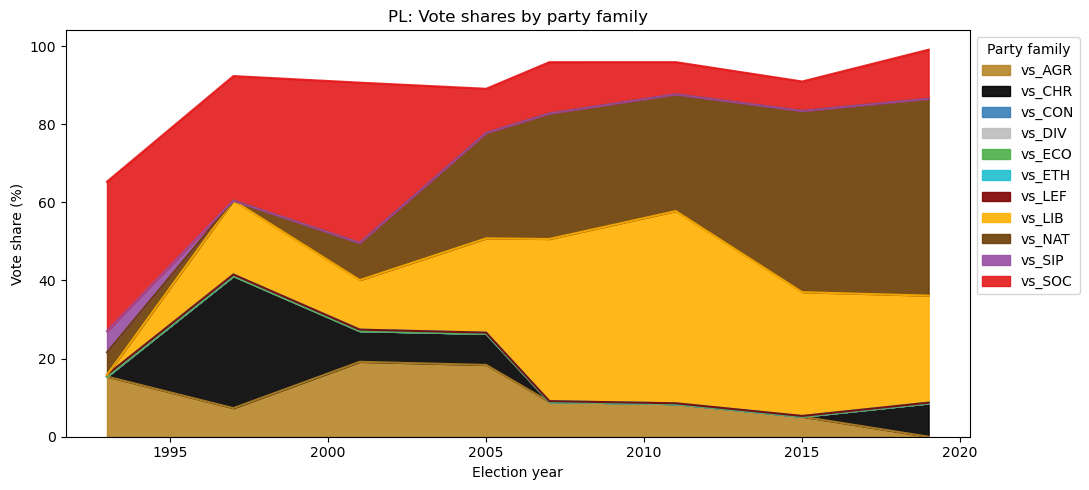

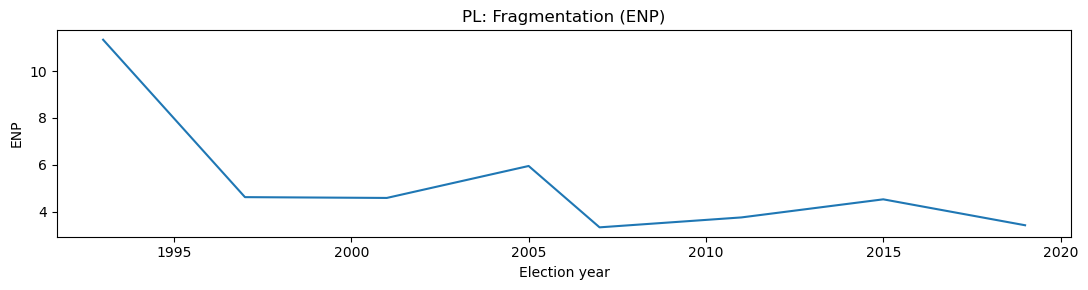

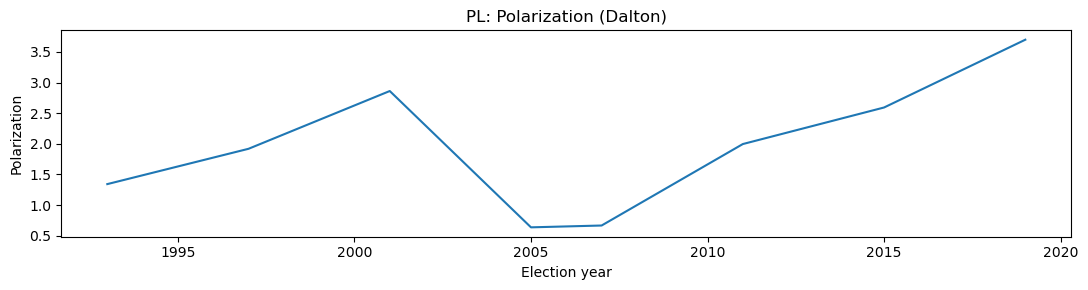


PL — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                LIB        up 1993–2011        8.97       49.20
                NAT        up 1993–2019        7.58       44.63
                CHR      down 1997–2011       -6.95      -33.83
                SOC      down 1997–2015       -7.14      -24.33
                AGR      down 2001–2019       -4.05      -19.18
                LIB      down 2007–2019       -7.91      -14.12
                CHR        up 2011–2019        4.27        8.55
                CHR        up 1993–2001        3.94        7.88
                SIP      down 1993–2001       -2.71       -5.41
                SOC        up 2011–2019        2.16        4.32
  fragmentation_enp      down 1993–2019       -1.32       -7.93
  fragmentation_enp        up 1997–2005        0.67        1.33
polarization_dalton        up 2005–2019        0.83        3.06
polarization_dalton        up 1993–2001        0.76        1.52


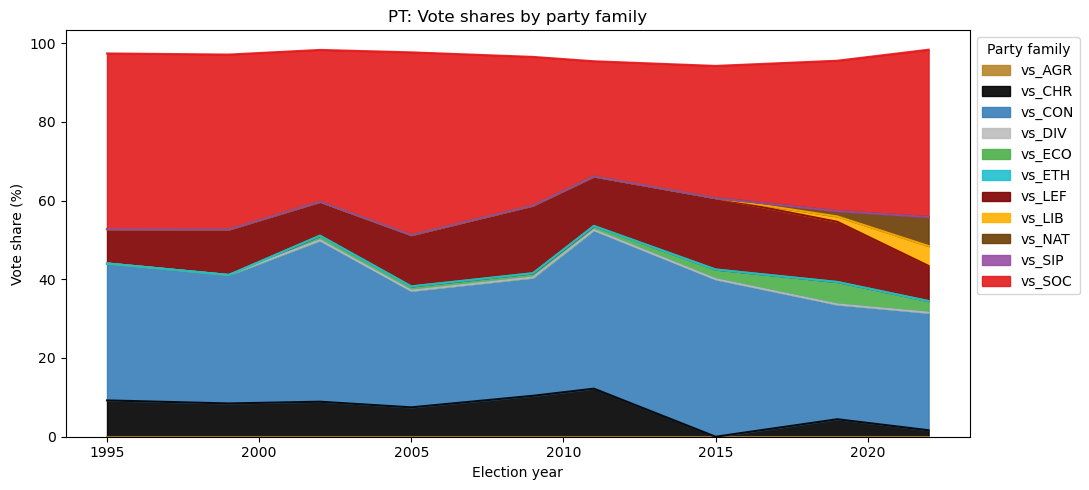

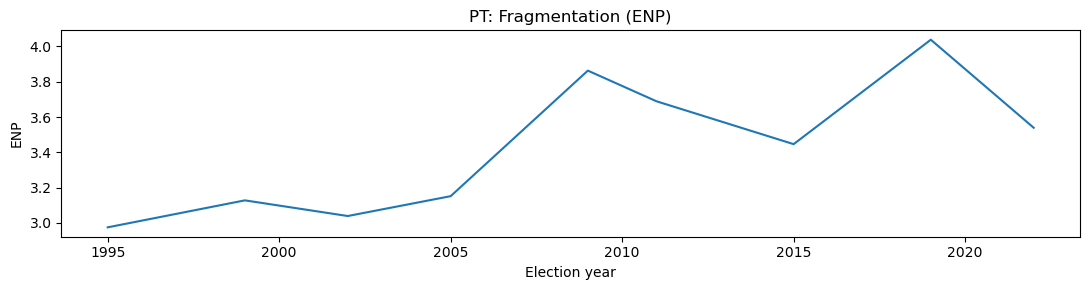

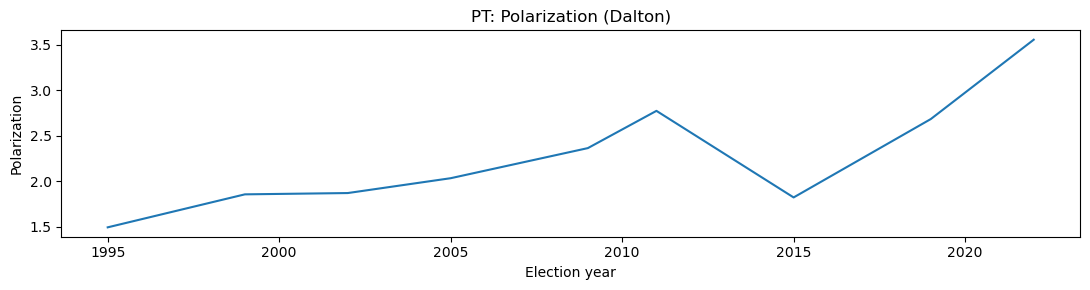


PT — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                SOC        up 2011–2022        4.47       13.26
                SOC      down 1995–2015       -3.52      -11.04
                CON      down 2011–2022       -5.32      -10.43
                CON        up 2005–2015        5.16       10.40
                LEF      down 2015–2022       -4.61       -9.21
                NAT        up 2011–2022        2.18        7.38
                CON        up 1995–2002        3.12        6.23
                CHR      down 2009–2019       -4.54       -5.96
                LIB        up 2011–2022        1.60        5.05
                ECO        up 2009–2019        1.51        4.61
  fragmentation_enp        up 2002–2019        0.29        1.00
  fragmentation_enp      down 2009–2015       -0.21       -0.42
polarization_dalton        up 2015–2022        0.87        1.74
polarization_dalton        up 1995–2011        0.27        1.28


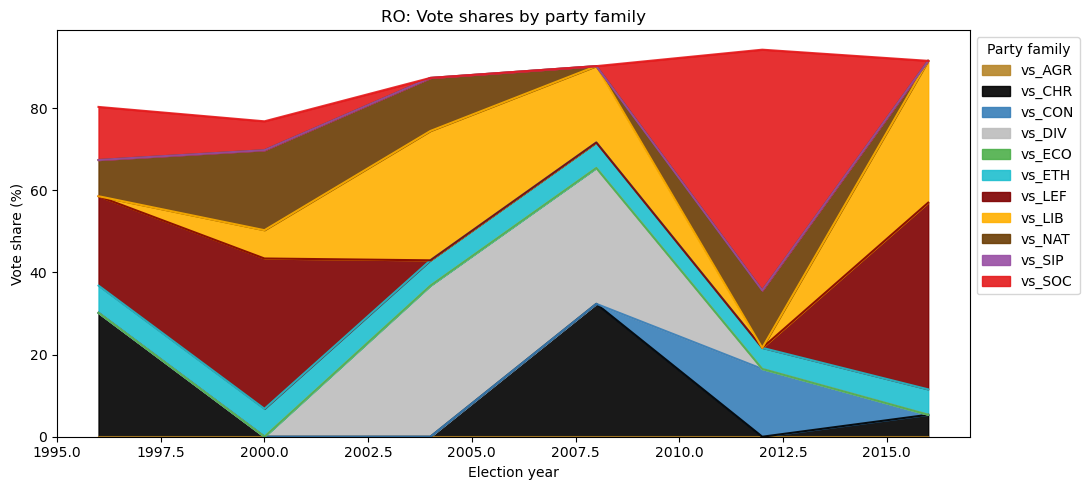

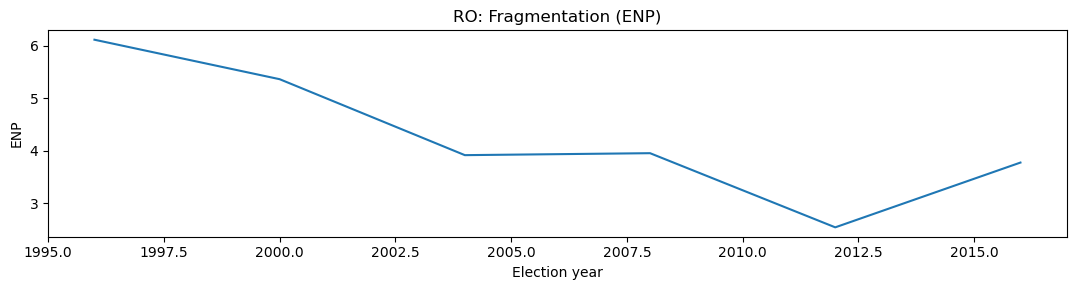

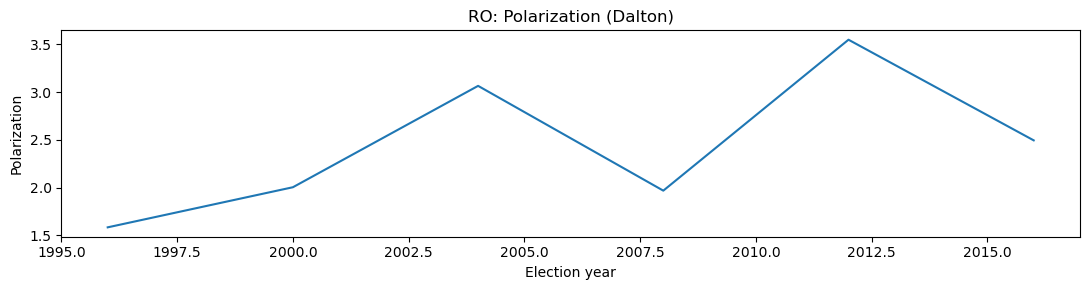


RO — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                SOC        up 2004–2012       29.32       58.63
                LEF        up 2008–2016       22.74       45.48
                DIV      down 2004–2016      -17.47      -36.80
                LIB        up 1996–2016        9.86       34.54
                DIV        up 1996–2008       17.47       33.10
                CHR        up 2000–2008       16.18       32.36
                LIB      down 2004–2012      -15.75      -31.50
                CHR      down 1996–2004      -15.08      -30.17
                CHR      down 2008–2016      -13.51      -27.02
                LEF      down 1996–2008      -14.59      -21.77
  fragmentation_enp      down 1996–2012       -0.83       -3.58
polarization_dalton        up 1996–2016        0.42        0.91


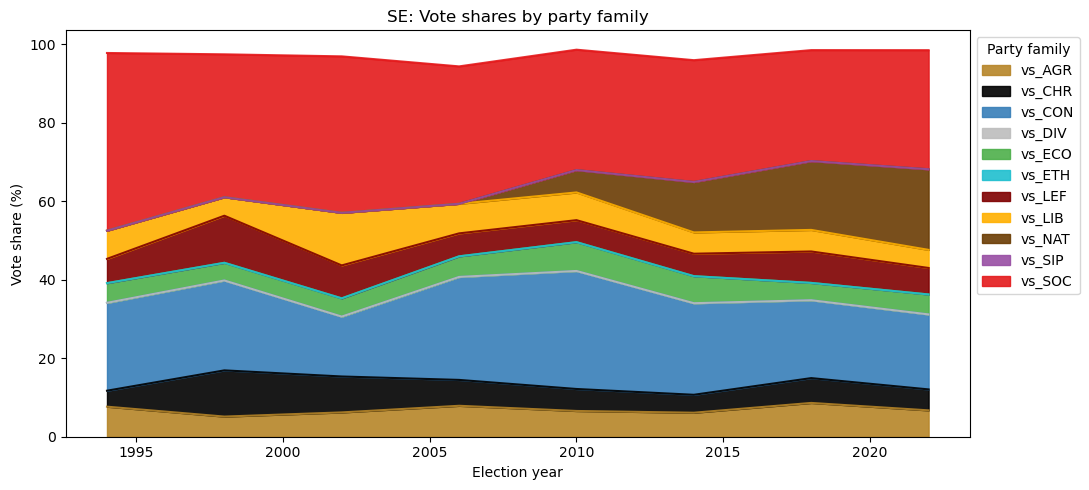

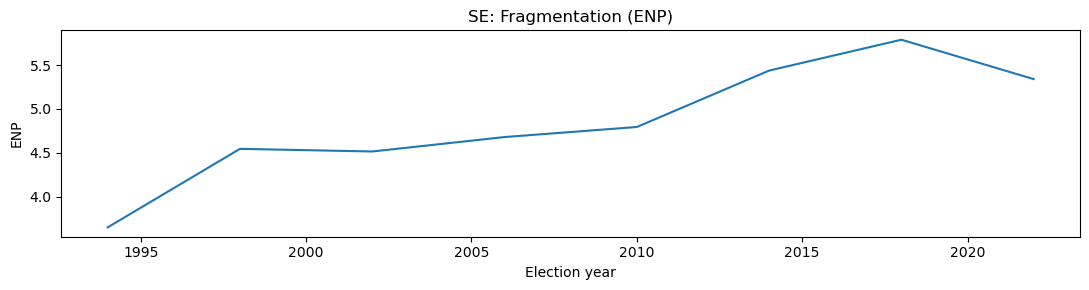

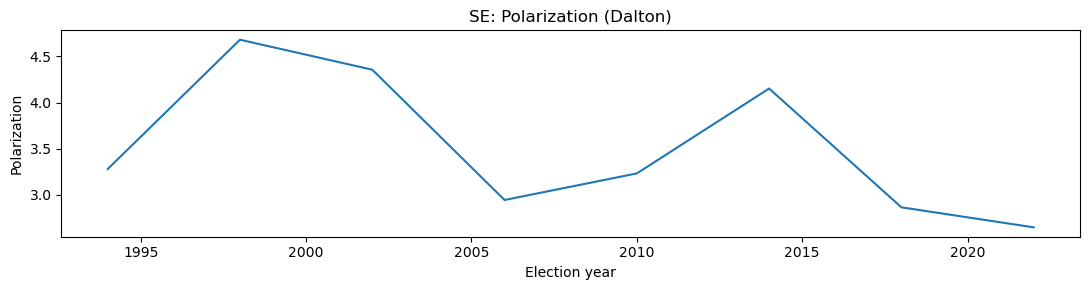


SE — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                NAT        up 2002–2022        4.76       20.54
                SOC      down 1994–2018       -2.24      -16.99
                LIB      down 2002–2022       -1.35       -8.79
                CHR      down 1998–2014       -1.79       -7.20
                CON        up 1998–2010        4.53        7.16
                CON      down 2006–2022       -2.89       -7.13
                CON      down 1994–2002       -3.56       -7.12
                LEF      down 1998–2010       -2.23       -6.39
                CHR        up 1994–2002        2.54        5.08
                AGR        up 1998–2006        1.37        2.75
  fragmentation_enp        up 2006–2018        0.44        1.11
  fragmentation_enp        up 1994–2002        0.43        0.86
polarization_dalton      down 1998–2022       -0.59       -2.03
polarization_dalton        up 2006–2014        0.60        1.21


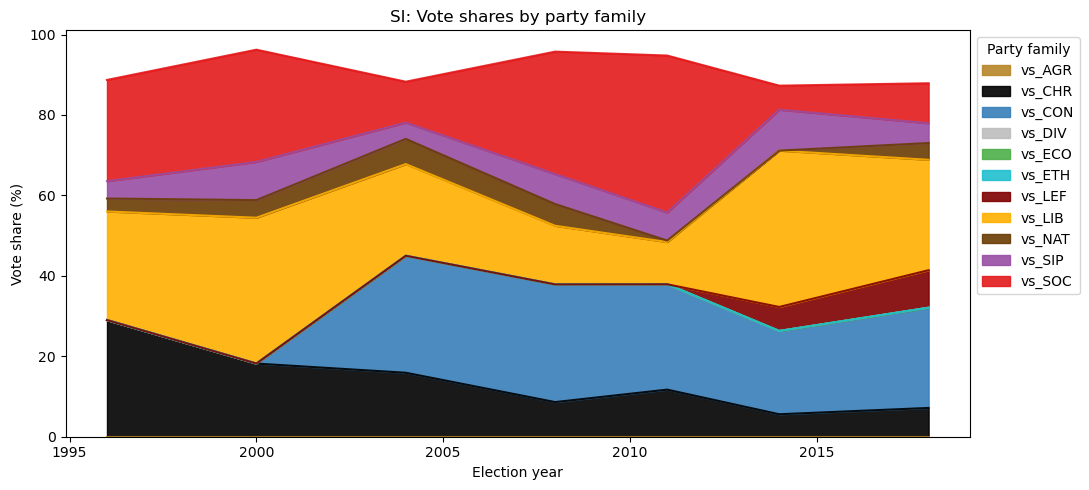

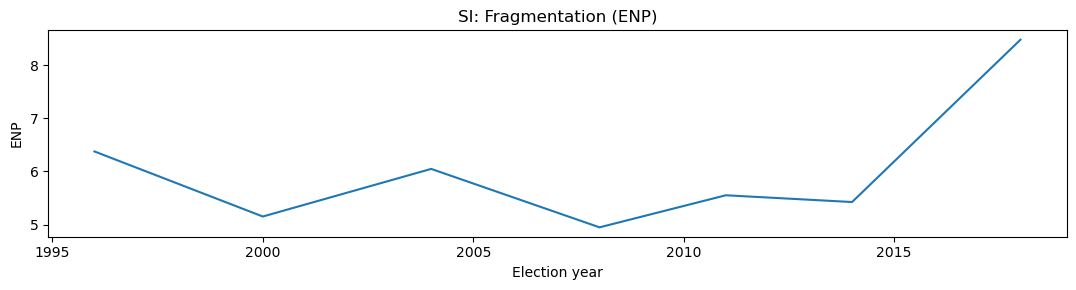

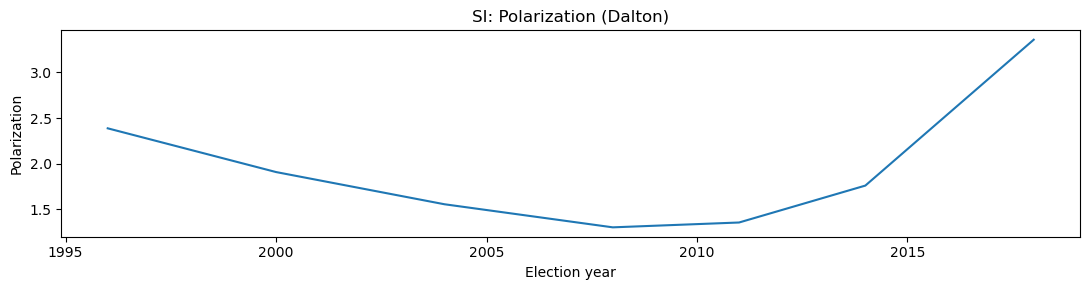


SI — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                CON        up 1996–2008       14.58       29.26
                CHR      down 1996–2018       -3.44      -21.84
                SOC      down 2008–2018      -13.39      -20.52
                LIB      down 1996–2011       -6.36      -16.51
                SOC      down 1996–2004       -7.50      -15.00
                LIB        up 2008–2018       10.31       12.87
                SOC        up 2000–2011        7.85       11.13
                LEF        up 2008–2018        3.82        9.33
                NAT      down 2004–2014       -2.83       -6.27
                SIP        up 2004–2014        1.41        6.14
  fragmentation_enp        up 2008–2018        0.85        3.53
  fragmentation_enp      down 1996–2011       -0.21       -0.83
polarization_dalton        up 2008–2018        0.62        2.06
polarization_dalton      down 1996–2008       -0.36       -1.09


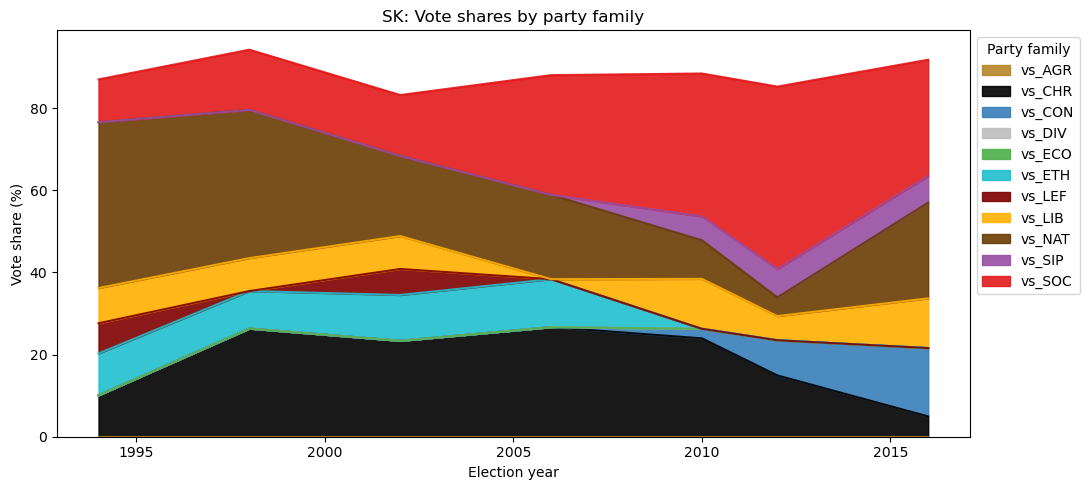

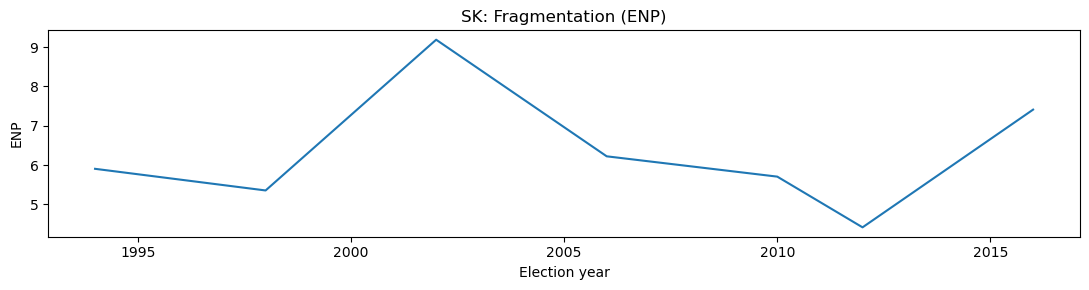

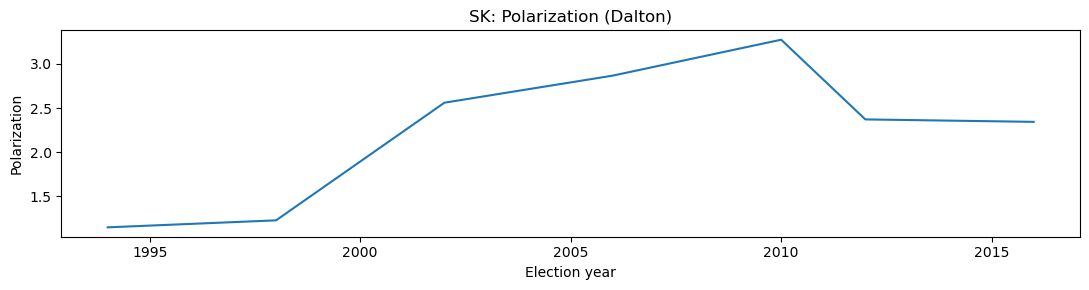


SK — Most important changes (>= 1993)
           variable direction    period  mean_slope  abs_change
                NAT      down 1994–2012       -7.81      -35.82
                SOC        up 1994–2012        6.77       34.00
                CHR      down 2006–2016       -7.69      -21.73
                CON        up 2002–2016        4.20       16.64
                NAT        up 2010–2016        6.96       13.92
                CHR        up 1994–2002        6.63       13.26
                ETH      down 2002–2012       -5.71      -11.17
                LIB      down 1998–2006       -4.01       -8.02
                LEF      down 1994–2010       -1.84       -7.35
                SIP        up 2002–2012        3.18        6.90
  fragmentation_enp      down 2002–2012       -1.32       -4.77
  fragmentation_enp        up 2010–2016        0.85        1.70
polarization_dalton        up 1994–2010        0.63        2.12
polarization_dalton      down 2006–2016       -0.36       -0.52


In [29]:
def plot_and_summarize(countries, elections_df, start_year=1993, k=3,thr_vs=0.4, thr_enp=0.15, thr_pol=0.15, top_vs=10, top_enp=2, top_pol=2):
    """
    For each country: plot vote-share stack, fragmentation index & polarization index, then print a compact table of top trend episodes (>= start_year).

    Input:
    countries: list of countries
    elections_df: election data set
    start-year: analyze years restriction
    k: rolling election window size
    thr_*: slope thresholds for detection
    top_*: how many strongest episodes to print per variable type

    Return:
    A dict: geo => per-country episodes table.
    """

    # country & time filter
    countries = [c for c in countries if c in elections_df.index.get_level_values(0)]
    ed = elections_df.loc[(countries, slice(start_year, None)), :]

    # data filter
    fam = [c for c in ed.columns if c.startswith("vs_")]
    cols = fam + ["fragmentation_enp", "polarization_dalton"]

    # compute episodes for one country
    def episodes_for(geo):
        g = ed.loc[geo, cols].sort_index()

        # rolling slope windows
        rows = []
        for col in cols:
            y, yrs = g[col], g.index
            for i in range(len(y)-k+1):
                w = y[i:i+k]
                if np.isnan(w).any(): continue
                # average change per election per (vs x party family, fragmentation and polarization)
                slope = np.polyfit(np.arange(k), w, 1)[0]
                thr = thr_vs if col.startswith("vs_") else (thr_enp if col=="fragmentation_enp" else thr_pol)
                if abs(slope) >= thr: rows.append((col, int(yrs[i]), int(yrs[i+k-1]), float(slope)))
        if not rows: 
            return g, pd.DataFrame(columns=["variable","direction","period","mean_slope","abs_change","pp_change"])

        # convert windows to episodes
        w = pd.DataFrame(rows, columns=["variable","from_year","to_year","slope"]).assign(sign=lambda x: np.sign(x.slope).astype(int))
        w = w.sort_values(["variable","sign","from_year","to_year"])
        prev = w.groupby(["variable","sign"])["to_year"].cummax().shift(fill_value=-10**9)
        w["ep"] = (w["from_year"] > prev).groupby([w["variable"], w["sign"]]).cumsum()

        ep = (w.groupby(["variable","sign","ep"], as_index=False).agg(from_year=("from_year","min"), to_year=("to_year","max"), mean_slope=("slope","mean")))

        # compute absolut change from original time series
        def ch(r):
            s = g[r.variable].dropna().loc[r.from_year:r.to_year]
            if len(s) < 2: return np.nan
            return float(s.iloc[-1] - s.iloc[0])

        ep["abs_change"] = ep.apply(ch, axis=1)
        ep = (ep.dropna(subset=["abs_change"])
                .assign(direction=lambda x: np.where(x.sign > 0, "up", "down"),
                        period=lambda x: x.from_year.astype(str) + "–" + x.to_year.astype(str),
                        mean_slope=lambda x: x.mean_slope.round(2),
                        abs_change=lambda x: x.abs_change.round(2),
                        variable=lambda x: np.where(x.variable.str.startswith("vs_"), x.variable.str[3:], x.variable),
                        impact=lambda x: x.abs_change.abs())
              )

        # select top episodes per country
        vs  = ep[~ep.variable.isin(["fragmentation_enp","polarization_dalton"])].nlargest(top_vs, "impact")
        enp = ep[ep.variable.eq("fragmentation_enp")].nlargest(top_enp, "impact")
        pol = ep[ep.variable.eq("polarization_dalton")].nlargest(top_pol, "impact")
        return g, pd.concat([vs, enp, pol])[["variable","direction","period","mean_slope","abs_change"]]

    # plot & print results
    out = {}
    for geo in countries:
        g, tab = episodes_for(geo)

        g[fam].plot.area(stacked=True, figsize=(11,5), alpha=.9, color=[FAMILY_COLORS[c] for c in fam], title=f"{geo}: Vote shares by party family")
        plt.xlabel("Election year"); plt.ylabel("Vote share (%)")
        plt.legend(loc="upper left", bbox_to_anchor=(1,1), title="Party family")
        plt.tight_layout(); plt.show()

        g["fragmentation_enp"].plot(figsize=(11,3), title=f"{geo}: Fragmentation (ENP)")
        plt.xlabel("Election year"); plt.ylabel("ENP")
        plt.tight_layout(); plt.show()

        g["polarization_dalton"].plot(figsize=(11,3), title=f"{geo}: Polarization (Dalton)")
        plt.xlabel("Election year"); plt.ylabel("Polarization")
        plt.tight_layout(); plt.show()

        print(f"\n{geo} — Most important changes (>= {start_year})")
        print(tab.to_string(index=False))
        out[geo] = tab.reset_index(drop=True)

    return out

# country lists
select_country = ["DE"]
all_countries

# select country and starting year
tables = plot_and_summarize(all_countries, elections, start_year=1993)